# [IAPR][iapr]: Lab 2 ‒  Object description

**Group ID:** 08

**Author 1 (sciper):** Luca Zunino (337560)  
**Author 2 (sciper):** Roberto Ceraolo (343261)   
**Author 3 (sciper):** Roberto Minini (336157)   

**Release date:** 25.03.2022  
**Due date:** 08.04.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path) as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

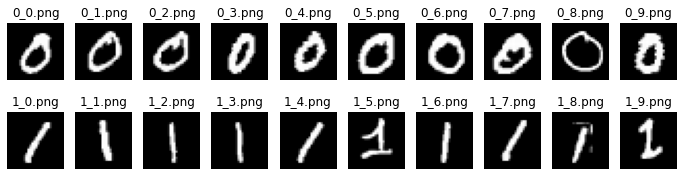

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')

# Plot images
def plot_grid(zeros_im, zeros_names, ones_im, ones_names):
    fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
    for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
        ax.imshow(im, cmap='gray')
        ax.axis('off')
        ax.set_title(nm)
    for ax, im, nm in zip(axes[1], ones_im, ones_names):
        ax.imshow(im, cmap='gray')
        ax.axis('off')
        ax.set_title(nm)
        
plot_grid(zeros_im, zeros_names, ones_im, ones_names)

### 1.2 Fourier descriptors (15 pts)

To explain the procedure implemented to obtain the Fourier descriptors starting from 28x28 grey-scale pictures of handwritten digits and how we pre-process each image, we start considering a single digit, and precisely the zero depicted in '0_0.png'. We will then introduce a procedure to repeat the same steps on all the images provided.

As a first step, we want to obtain a binary image in which the digit (foreground) and the black background are clearly distinct. To do so, we apply many different thresholds to check which one is better for our application:

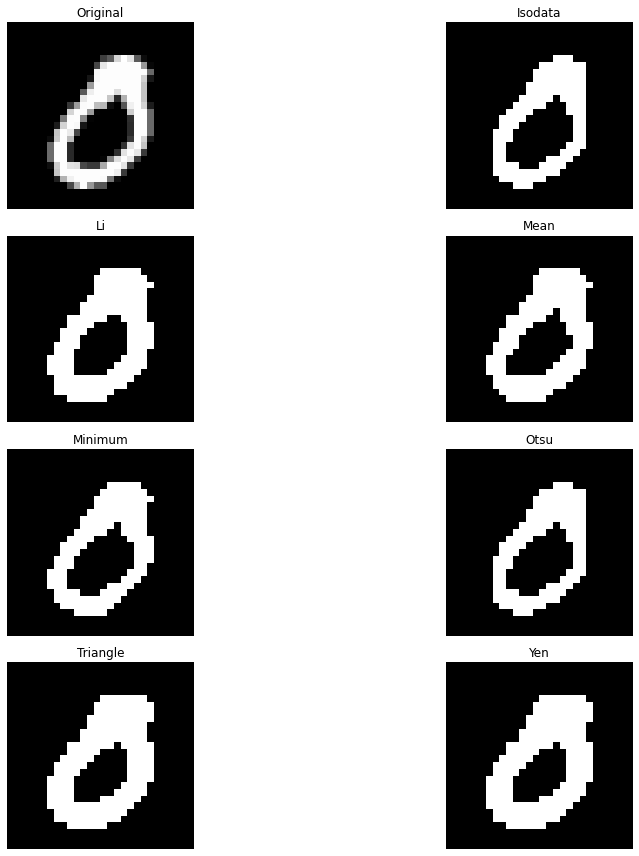

In [3]:
import matplotlib.pyplot as plt
from skimage.filters import try_all_threshold

# We consider the first zero image
img = zeros_im[0]

# We apply many thresholds to the image
fig, ax = try_all_threshold(img, figsize=(16, 12), verbose=False)
plt.show()

Since, in this case, the background and the object are clearly distinct, all the applied thresholds give good results (although some minor differences can be observed). In order to decide which threshold is better, we can consider a slightly more complicated case, that is, the one in which the digit is not clearly defined. This can be seen, in particular, in the digit contained in '1_8.png'. Indeed, the digit is surrounded by some bright pixels that should not be considered as part of the foreground. To solve this issue, and, more in general, to obtain better results in the following steps, we can apply an area opening and a median filter. We will consider, for the moment, the image '1_8.png' as exhibits some non-idealities that we have to take into account when choosing the pre-processing methods and the thresholding method. The original image is displayed below:

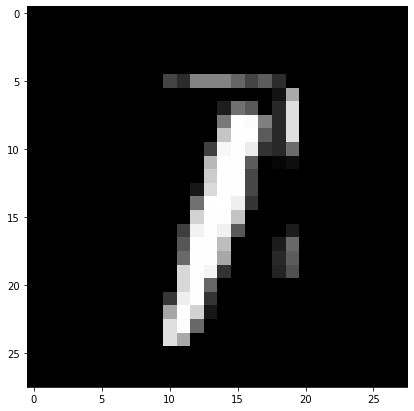

In [4]:
img = ones_im[8]

plt.figure(figsize=(12, 7))
plt.imshow(img, cmap='gray')
plt.show()

At this point, we apply an area opening with the parameter area_threshold set to 24:

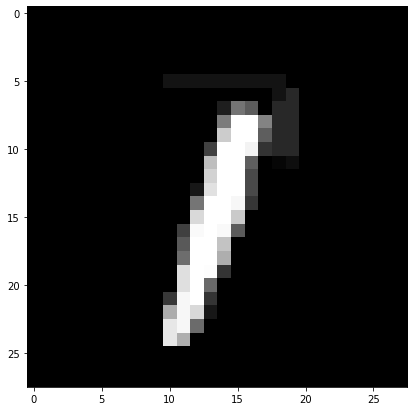

In [5]:
img = skimage.morphology.area_opening(img, area_threshold=24, connectivity=1)

plt.figure(figsize=(12, 7))
plt.imshow(img, cmap='gray')
plt.show()

We can see that thanks to the area opening, the bright pixels that surrounded the digit become darker. To make the code more robust, we can also apply a median filter:

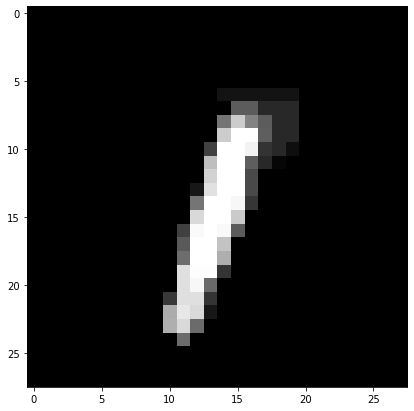

In [6]:
import scipy

img = scipy.signal.medfilt2d(img)

plt.figure(figsize=(12, 7))
plt.imshow(img, cmap='gray')
plt.show()

The median filter keeps the contours of the digit sharp but helps filter out some noisy pixels.

Note that we decided to apply an area opening and a median filtering considering the characteristics of the forty images proposed (ten '0', ten '1', ten '2', ten '3'), but additional pre-processing may be necessary if a more extended data-set is to be considered. In particular, better results are reached when closed digits (e.g. '0', '8') are connected as we will need to visit the contour of the digits.

At this point, considering the processed digit contained in '1_8.png', we can apply many different thresholds to see whether they all give good results as it was for the zero contained in '0_0.jpg':

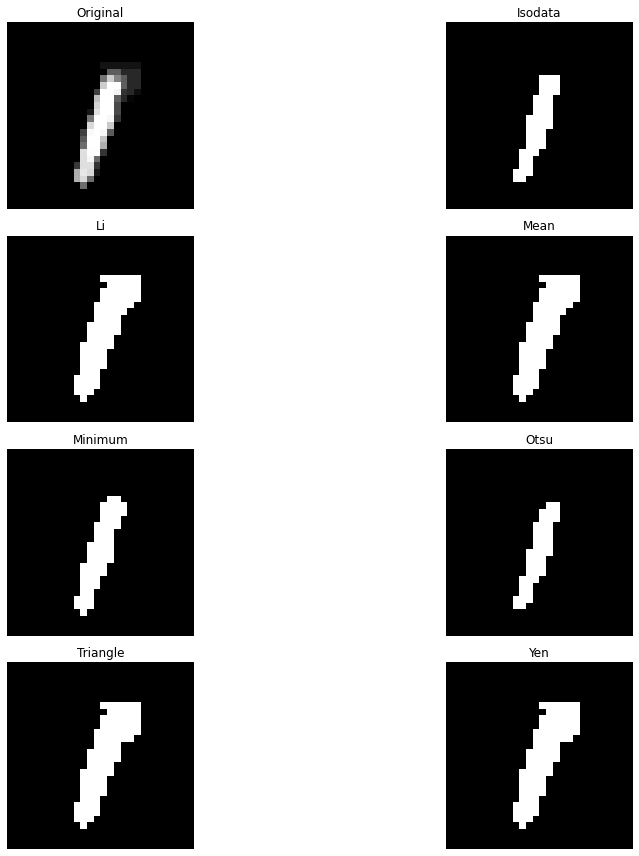

In [7]:
# We apply many thresholds to the image
fig, ax = try_all_threshold(img, figsize=(16, 12), verbose=False)
plt.show()

At this point, we can notice some differences in the results. In particular, some of the filters produce an unnatural shape on the upper part of the digits due to the fact that the pixels that have been removed thanks to the area opening and filtered by the median filter are not exactly black. The thresholding methods Isodata, Minimum and Otsu seem to give good results. The procedure that is described in the following has been repeated considering each of these three thresholding methods, and the results obtained were similar. In the following, we will consider the Minimum thresholding method. At this point, we can obtain the binary image by applying the Minimum thresholding method. Note that, from now on, we take again the digit contained in '0_0.jpg' as an example.

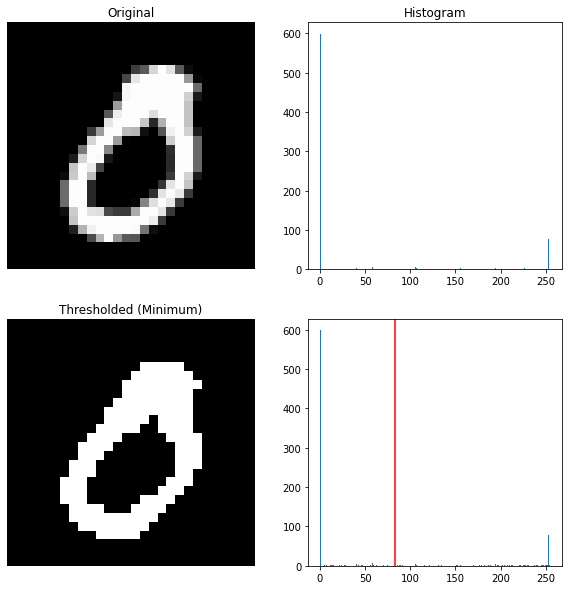

In [8]:
from skimage.filters import threshold_minimum

img = zeros_im[0]

# Select a threshold based on the Minimum thresholding method
thresh = threshold_minimum(img)
binary = img > thresh

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(img, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')
ax[0, 1].hist(img.ravel(), bins=256)
ax[0, 1].set_title('Histogram')
ax[1, 0].imshow(binary, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (Minimum)')
ax[1, 1].hist(img.ravel(), bins=256)
ax[1, 1].axvline(thresh, color='r')
for a in ax[:, 0]:
    a.axis('off')
plt.show()

At this point, we want to obtain the contour of the digit, and to ease the following step of the algorithm (where we will have to follow the contour in order), the best way to proceed is to find a contour with single-pixel width. To obtain this, we consider the following procedure:
- We start analyzing the image from above to below. For each column, we visit the rows from top to bottom until we find a pixel belonging to the digit (that has a value of 1 in the binary image). This pixel will be part of the single-pixel width contour, and we skip all the pixels in the subsequent rows that are connected to the first pixel found. The first pixel not connected to the first pixel found will be again part of the contour, then we skip all the connected pixels again and so on, until visiting all the rows of a given column.
- We then analyze the image from left to right. For each row, we visit the columns from left to right until we find a pixel belonging to the digit; we then repeat the procedure described above.
- We then analyze the image from below to above. For each column, we visit the rows from bottom to top until we find a pixel belonging to the digit; we then repeat the procedure described above.
- We finally analyze the image from right to left. For each row, we visit the columns from right to left until we find a pixel belonging to the digit; we then repeat the procedure described above.
At the end of these steps, we obtain a contour with single-pixel width:

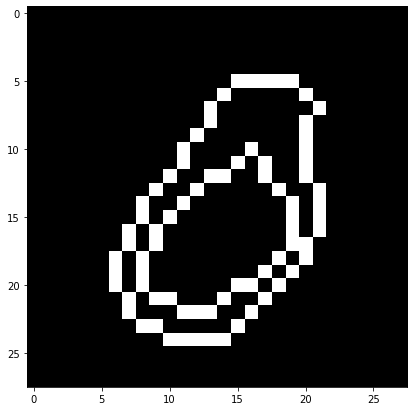

In [9]:
import numpy as np

new = np.zeros((img.shape[0], img.shape[1]))
       
# Image analyzed from above to below
for col in range(28):
    row = 0
    while (row < 28):
        if (binary[row, col] == 1):
            new[row, col] = 1
            while (row < 28 and binary[row, col] == 1):
                row = row + 1
        else:
            row = row + 1
            
# image analyzed from left to right
for row in range(28):
    col = 0
    while (col < 28):
        if (binary[row, col] == 1):
            new[row, col] = 1
            while (col < 28 and binary[row, col] == 1):
                col = col + 1
        else:
            col = col + 1
            
# image analyzed from below to above
for col in range(28):
    row = 27
    while (row >= 0):
        if (binary[row, col] == 1):
            new[row, col] = 1
            while (row >= 0 and binary[row, col] == 1):
                row = row - 1
        else:
            row = row - 1
            
# image analyzed from right to left
for row in range(28):
    col = 27
    while (col >= 0):
        if (binary[row, col] == 1):
            new[row, col] = 1
            while (col >= 0 and binary[row, col] == 1):
                col = col - 1
        else:
            col = col - 1
            
plt.figure(figsize=(12, 7))
plt.imshow(new, cmap='gray')
plt.show()

The result is satisfactory, as we obtain a single-pixel wide contour. We can see that, in this case, both the inner and the outer contours are present in the image. This is not a problem, but in the following, we will concentrate on the outer contour of the digit.

Note that it would have been possible to obtain very similar results considering the Canny algorithm:

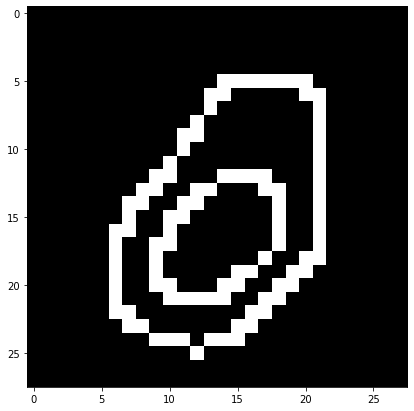

In [10]:
from skimage import feature

image = binary

# Computation of the Canny filter
edges = feature.canny(image, sigma=0.9)

# Plot of the result
plt.figure(figsize=(12, 7))
plt.imshow(edges, cmap='gray')
plt.show()

Even if the Canny algorithm provides satisfactory results, we will stick to the first implementation described.
At this point, we still have to visit the pixels composing the outer contour in order. To do so, we, first of all, define a function, 'find_start', that takes a binary image as input and returns the first pixel of the contour. In order to find the first pixel, the pixels are parsed from top-left to bottom-right (raster scan order).

In [11]:
def find_start(img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if (img[i, j] == 1):
                # First point found
                return i,j
    # No point found
    return -1,-1

At this point, we have the starting pixel and the contour, but we still need to obtain the list of pixels visited in order. First of all, we define some preliminary rules on which the implemented algorithm is based:
- Given a certain pixel, we consider adjacent pixels the ones horizontally, vertically or diagonally adjacent.
- Considering a pixel belonging to the contour, already inserted in the list of visited pixels, the successive visited pixel must be adjacent and must be part of the contour. Therefore, eight moves are possible: up, up-right (45°), right, down-right, down, down-left, left, up-left.
- Considering a pixel belonging to the contour, if more than one of the adjacent pixels belongs to the contour, the one that is visited (and therefore inserted in the list) is decided considering the array pos_order. This array contains the ranking of the positions to visit (0 indicates the position that we are more interested in visiting, and 7 indicates the position that we are less interested in visiting). The value stored in position 0 of the array is related to the movement 'up', the value stored in position 1 to 'up-right', the value stored in position 2 to 'right', the value stored in position 3 to 'down-right', the value stored in position 4 to 'down', the value stored in position 5 to 'down-left', the value stored in position 6 to 'left', the value stored in position 7 to 'up-left'.
- The visiting ranking stored in 'pos_order' is updated after each movement, as we always want to remain in the outer part of the contour. For example, if we are moving down, the array is updated as follows: pos_order = [6, 7, 0, 1, 2, 3, 4, 5]. Indeed, we would like to move right (if possible) to be sure to remain in the outer part of the contour. At the start of the algorithm, since we do not have yet a traveling direction, we assume that we will go right in the next time step, as we have identified the top-left pixel of the digit.

Apart from these preliminary considerations, the algorithm is quite straight-forward:
- We consider the pixel currently under analysis and the eight adjacent pixels. We visit the adjacent pixel with the highest rank (given by the array 'pos_order') that has not been visited yet and that belongs to the digit (i.e., that has value 1).
- Once we visit a pixel, we mark it as visited, and we store the x coordinate of the visited pixel in the array 'list_x' and the y coordinate of the visited pixel in the array 'list_y'.
- We repeat these two steps until we are able to visit the first visited pixel of the contour again.

Note that the following code cell produces a very high number of plots. Considered in order, these plots show that, indeed, the contour is visited in order.

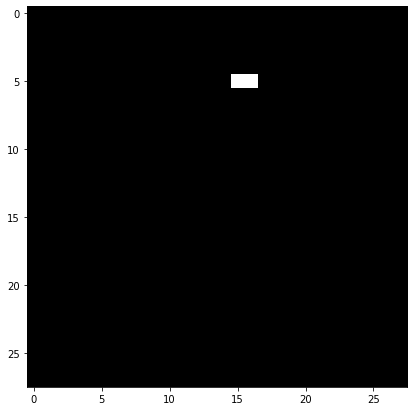

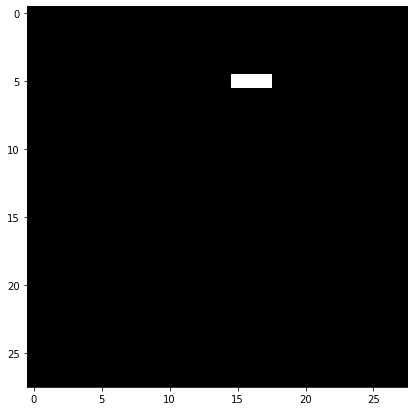

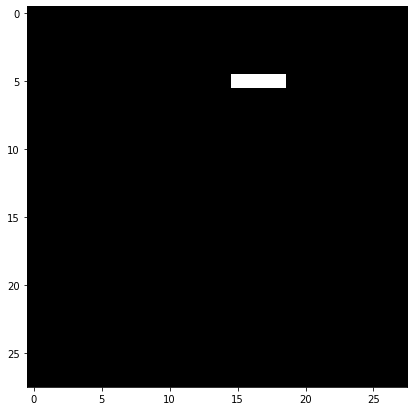

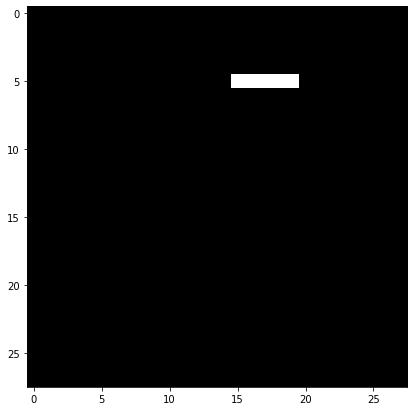

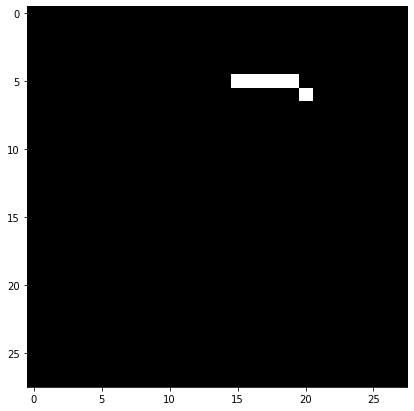

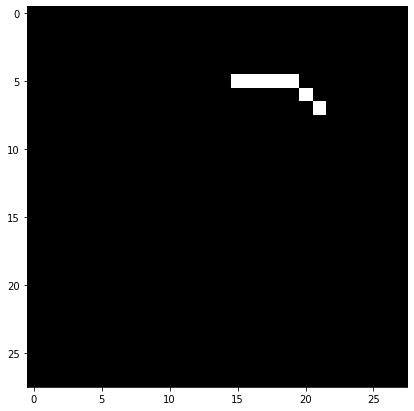

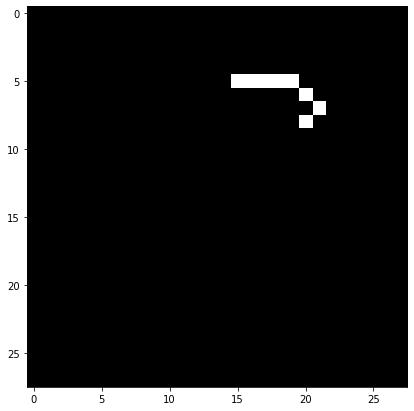

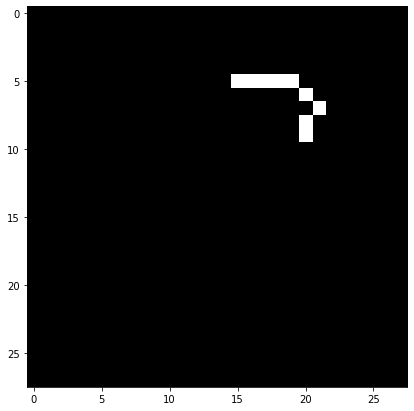

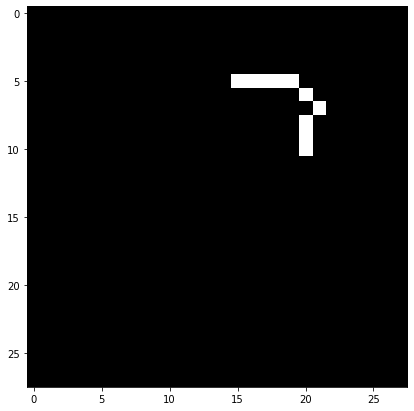

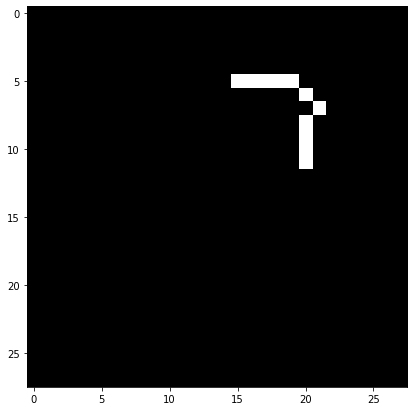

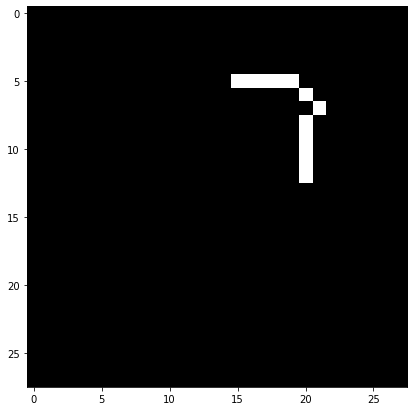

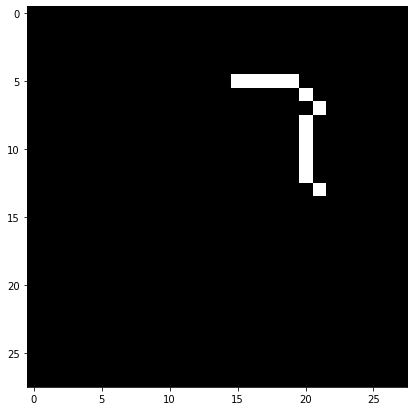

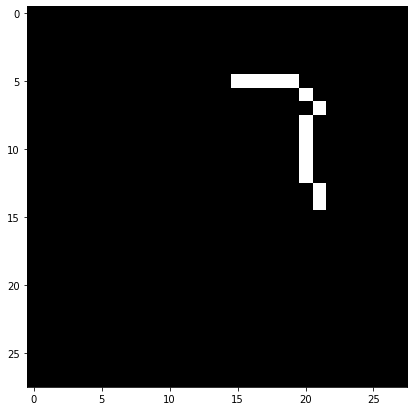

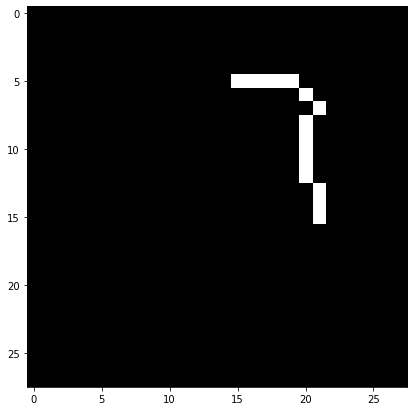

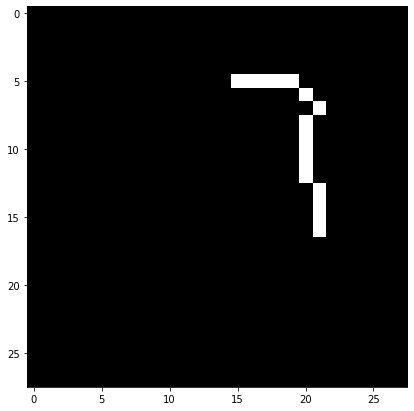

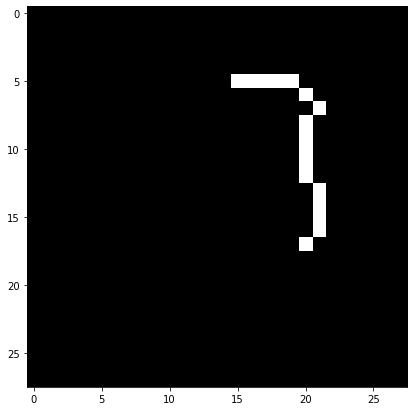

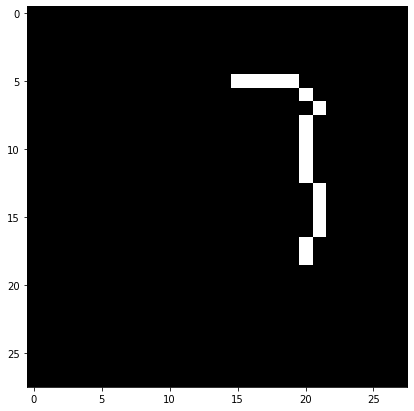

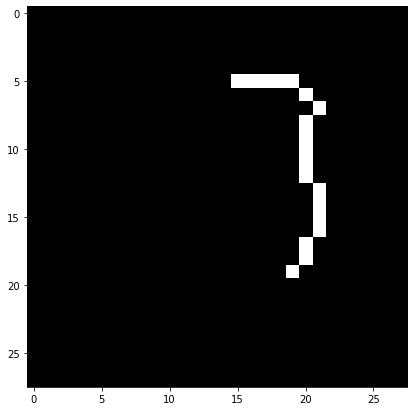

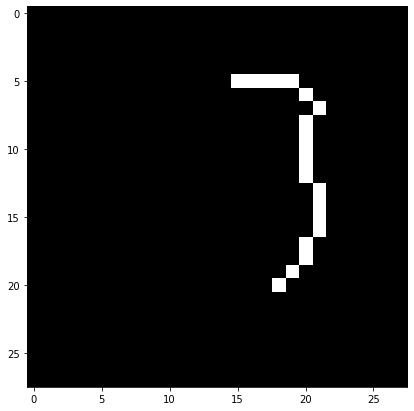

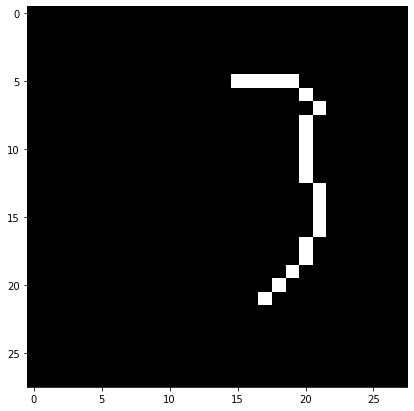

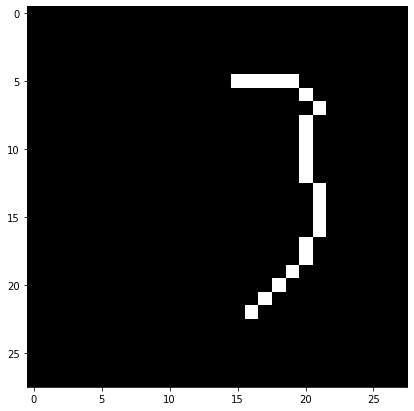

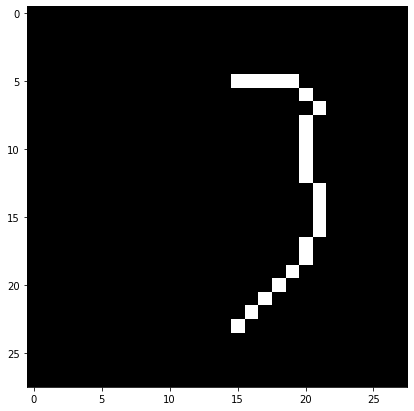

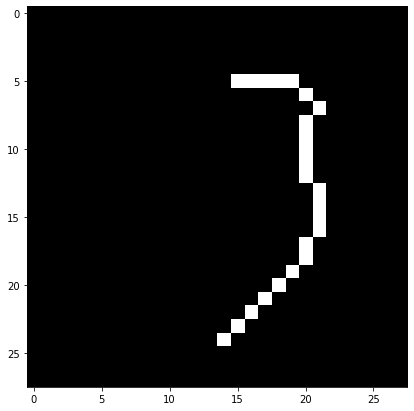

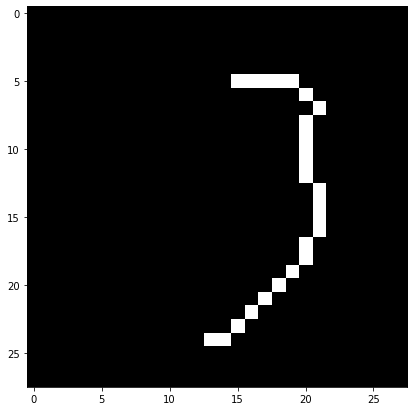

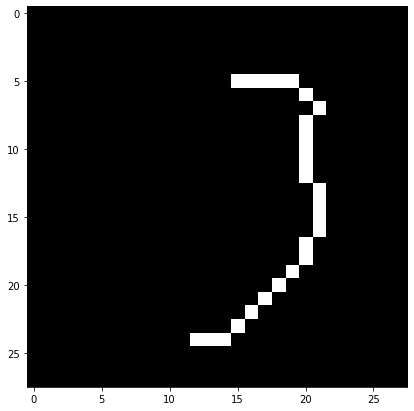

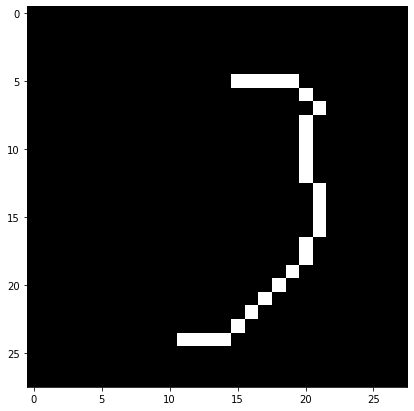

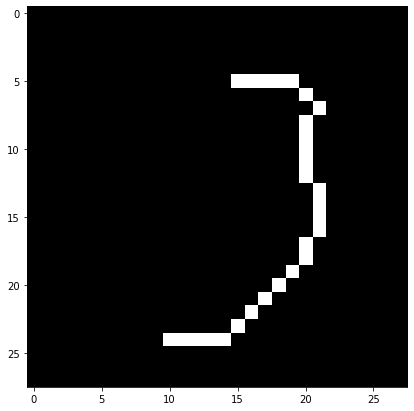

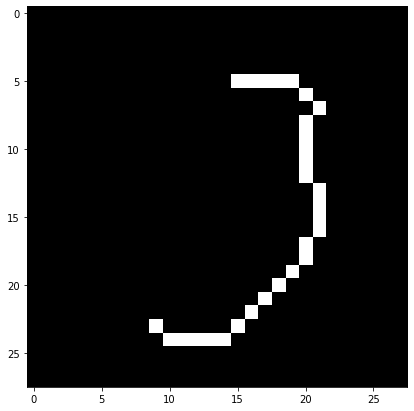

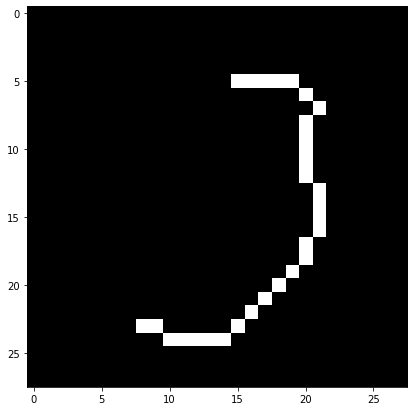

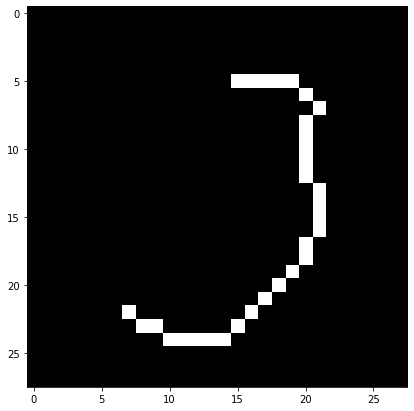

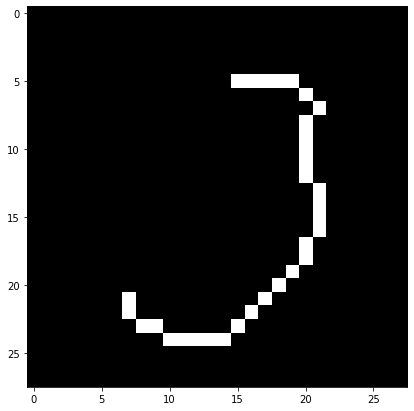

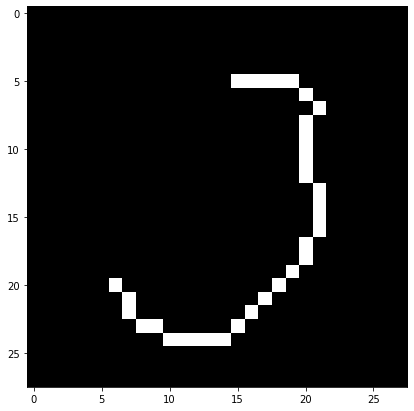

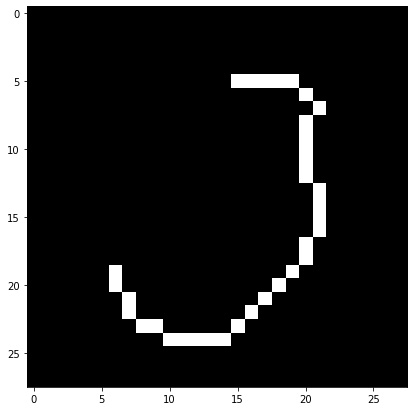

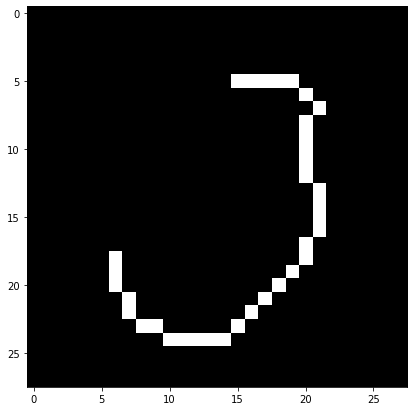

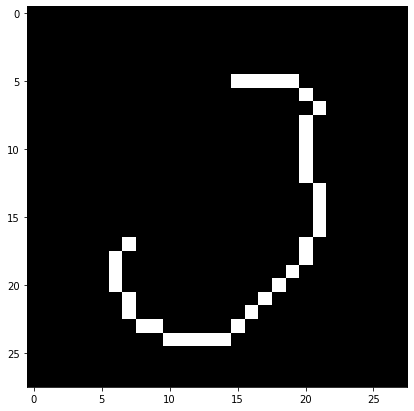

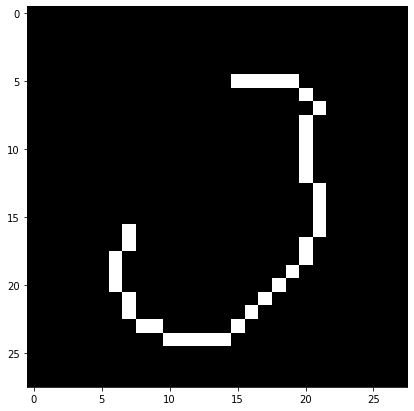

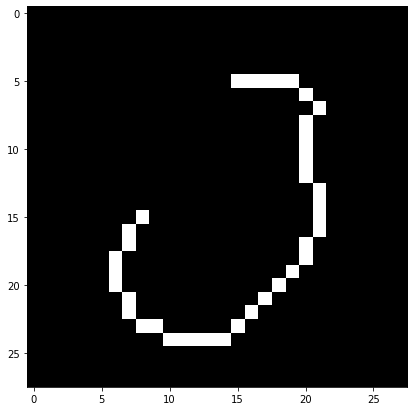

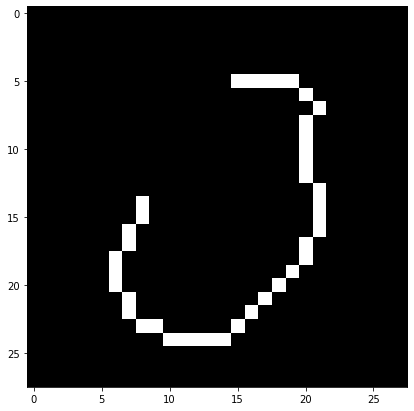

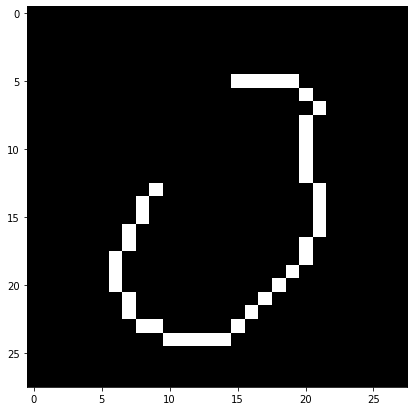

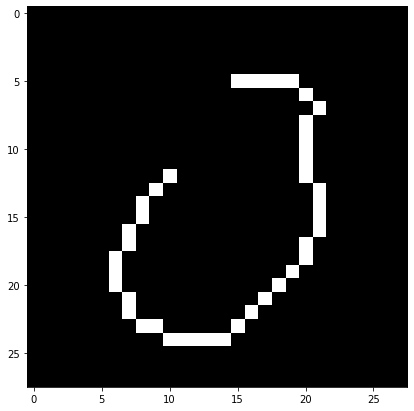

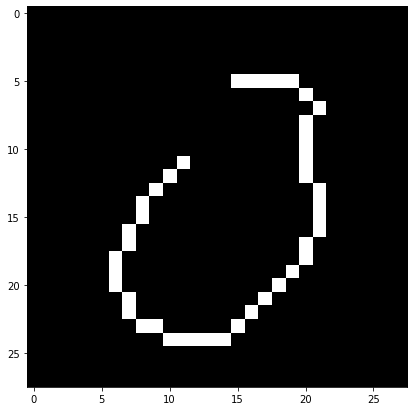

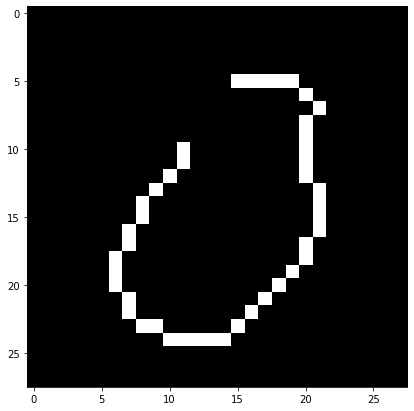

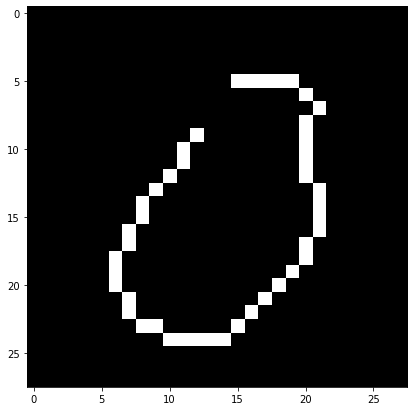

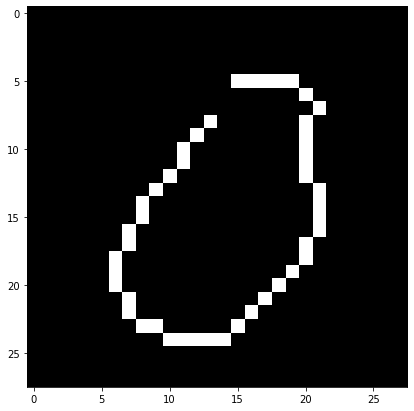

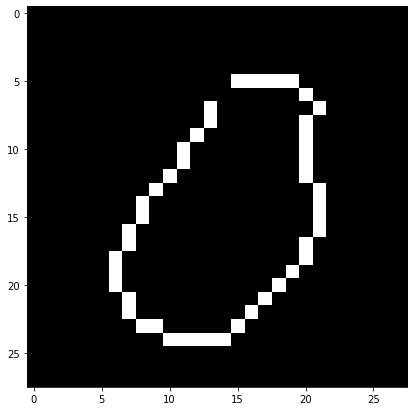

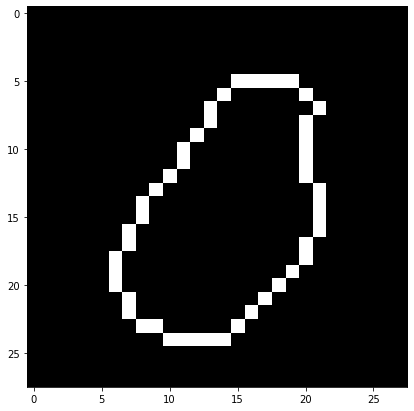

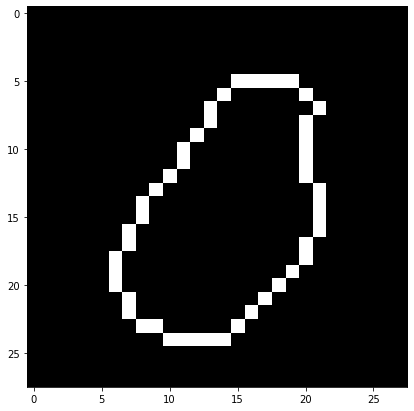

In [12]:
# We find the coordinates of the first pixel of the digit
start_i, start_j = find_start(new)

# We set the flag that indicates whether we visited the entire contour to 0
finish = 0

# We initialize to zero the matrix that keeps trace of which pixels we visited during the algorithm
contour = np.zeros((28,28))

# We consider the starting pixel of the digit
contour[start_i, start_j] = 1
i = start_i
j = start_j

# We initialize to zero the array that indicates which positions are available, i.e. which pixels have not been
# visited yet and belong to the contour
# pos_available[0]: up, pos_available[1]: up-right, pos_available[2]: right, pos_available[3]: down-right, 
# pos_available[4]: down, pos_available[5]: down-left, pos_available[6]: left, pos_available[7]: up-left
pos_available = np.zeros(8) # Starts from h12 in a clock 

# We initialize the array that contains the visiting ranking
# pos_order[0]: up, pos_order[1]: up-right, pos_order[2]: right, pos_order[3]: down-right, 
# pos_order[4]: down, pos_order[5]: down-left, pos_order[6]: left, pos_order[7]: up-left
pos_order = [0, 1, 2, 3, 4, 5, 6, 7] # Starts from h12 in a clock

# We initialize the lists that will contain the coordinates of the pixels of the contour, visited in order
list_x = []
list_y = []

# While we have not finished visiting all the pixels of the contour
while (finish == 0):
    # We initialize to zero the array that indicates which positions are available, i.e. which adjacent pixels
    # have not been visited yet and belong to the contour
    pos_available = [0, 0, 0, 0, 0, 0, 0, 0]
    # We initialize to zero the array that indicates which positions are hypotetically available, i.e. which
    # adjacent pixels belong to the contour (this is useful to check whether the starting pixel is adjacent)
    pos_hyp_available = [0, 0, 0, 0, 0, 0, 0, 0]
    # For each adjacent pixel, we check whether it belongs to the contour and whether it is still to be visited,
    # and we update pos_available accordingly
    if (new[i-1, j] == 1 and contour[i-1, j] == 0):
        pos_available[0] = 1
    if (new[i-1, j+1] == 1 and contour[i-1, j+1] == 0):
        pos_available[1] = 1
    if (new[i, j+1] == 1 and contour[i, j+1] == 0):
        pos_available[2] = 1
    if (new[i+1, j+1] == 1 and contour[i+1, j+1] == 0):
        pos_available[3] = 1
    if (new[i+1, j] == 1 and contour[i+1, j] == 0):
        pos_available[4] = 1
    if (new[i+1, j-1] == 1 and contour[i+1, j-1] == 0):
        pos_available[5] = 1
    if (new[i, j-1] == 1 and contour[i, j-1] == 0):
        pos_available[6] = 1
    if (new[i-1, j-1] == 1 and contour[i-1, j-1] == 0):
        pos_available[7] = 1
    # For each adjacent pixel, we check whether it belongs to the contour, and we update pos_hyp_available
    # accordingly
    if (new[i-1, j]):
        pos_hyp_available[0] = 1
    if (new[i-1, j+1]):
        pos_hyp_available[1] = 1
    if (new[i, j+1] == 1):
        pos_hyp_available[2] = 1
    if (new[i+1, j+1] == 1):
        pos_hyp_available[3] = 1
    if (new[i+1, j] == 1):
        pos_hyp_available[4] = 1
    if (new[i+1, j-1] == 1):
        pos_hyp_available[5] = 1
    if (new[i, j-1] == 1):
        pos_hyp_available[6] = 1
    if (new[i-1, j-1] == 1):
        pos_hyp_available[7] = 1
            
    # We sort the indices corresponding to the positions that we would like to visit, considering the rank in 
    # pos_order
    ind = np.argsort(pos_order)

    # We choose the available movement with the highest ranking
    chosen = 0
    for index in ind:
        if (pos_available[index] == 1 and chosen == 0):
            chosen_ind = index
            chosen = 1
    # If no movement is available, we stop
    if (chosen == 0):
        finish = 1
        
    # We check whether one of the adjacent pixels belonging to the contour is the starting one
    chosen = 0
    for index in ind:
        if (pos_hyp_available[index] == 1 and chosen == 0):
            chosen_hyp_ind = index
            chosen = 1
    # If no movement is available, we stop
    if (chosen == 0):
        finish = 1
    # If one of the adjacent pixels belonging to the contour is the starting one, we stop
    if chosen_hyp_ind == 0: # Going up
        if (i-1 == start_i and j == start_j):
            finish = 1
    if chosen_hyp_ind == 1: # Going up-right
        if (i-1 == start_i and j+1 == start_j):
            finish = 1
    if chosen_hyp_ind == 2: # Going right
        if (i == start_i and j+1 == start_j):
            finish = 1
    if chosen_hyp_ind == 3: # Going down-right
        if (i+1 == start_i and j+1 == start_j):
            finish = 1
    if chosen_hyp_ind == 4: # Going down
        if (i+1 == start_i and j == start_j):
            finish = 1
    if chosen_hyp_ind == 5: # Going down-left
        if (i+1 == start_i and j-1 == start_j):
            finish = 1
    if chosen_hyp_ind == 6: # Going left
        if (i == start_i and j-1 == start_j):
            finish = 1
    if chosen_hyp_ind == 7: # Going up-left
        if (i-1 == start_i and j-1 == start_j):
            finish = 1
            
    # If we have not reached the end of the algorithm, we move on the contour and we update the visited positions
    # and the lists containing the x and y coordinates of the visited pixels (list_x, list_y)
    if chosen_ind == 0 and finish == 0: # Going up
        contour[i-1, j] = 1
        i = i-1
        j = j
        list_y = np.append(list_y, i)
        list_x = np.append(list_x, j)
        pos_order = [2, 3, 4, 5, 6, 7, 0, 1]
    if chosen_ind == 1 and finish == 0: # Going up-right
        contour[i-1, j+1] = 1
        i = i-1
        j = j+1
        list_y = np.append(list_y, i)
        list_x = np.append(list_x, j)
        pos_order = [1, 2, 3, 4, 5, 6, 7, 0]
    if chosen_ind == 2 and finish == 0: # Going right
        contour[i, j+1] = 1
        i = i
        j = j+1
        list_y = np.append(list_y, i)
        list_x = np.append(list_x, j)
        pos_order = [0, 1, 2, 3, 4, 5, 6, 7]
    if chosen_ind == 3 and finish == 0: # Going down-right
        contour[i+1, j+1] = 1
        i = i+1
        j = j+1
        list_y = np.append(list_y, i)
        list_x = np.append(list_x, j)
        pos_order = [7, 0, 1, 2, 3, 4, 5, 6]
    if chosen_ind == 4 and finish == 0: # Going down
        contour[i+1, j] = 1
        i = i+1
        j = j
        list_y = np.append(list_y, i)
        list_x = np.append(list_x, j)
        pos_order = [6, 7, 0, 1, 2, 3, 4, 5]
    if chosen_ind == 5 and finish == 0: # Going down-left
        contour[i+1, j-1] = 1
        i = i+1
        j = j-1
        list_y = np.append(list_y, i)
        list_x = np.append(list_x, j)
        pos_order = [5, 6, 7, 0, 1, 2, 3, 4]
    if chosen_ind == 6 and finish == 0: # Going left
        contour[i, j-1] = 1
        i = i
        j = j-1
        list_y = np.append(list_y, i)
        list_x = np.append(list_x, j)
        pos_order = [4, 5, 6, 7, 0, 1, 2, 3]
    if chosen_ind == 7 and finish == 0: # Going up-left
        contour[i-1, j-1] = 1
        i = i-1
        j = j-1
        list_y = np.append(list_y, i)
        list_x = np.append(list_x, j)
        pos_order = [3, 4, 5, 6, 7, 0, 1, 2]
        
    # At each step, we plot the evolution of the visited position, to show that the contour is indeed visited
    # in order
    plt.figure(figsize=(12, 7))
    plt.imshow(contour, cmap='gray')
    plt.show()

At this point, we have the ordered lists of the x and y coordinates of all the pixels belonging to the contour that has been visited in order:

In [13]:
print(list_x) # X-coordinate for each point of the contour (visited in order)
print(list_y) # Y-coordinate for each point of the contour (visited in order)

[16. 17. 18. 19. 20. 21. 20. 20. 20. 20. 20. 21. 21. 21. 21. 20. 20. 19.
 18. 17. 16. 15. 14. 13. 12. 11. 10.  9.  8.  7.  7.  6.  6.  6.  7.  7.
  8.  8.  9. 10. 11. 11. 12. 13. 13. 14.]
[ 5.  5.  5.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 24. 24. 24. 24. 23. 23. 22. 21. 20. 19. 18. 17. 16.
 15. 14. 13. 12. 11. 10.  9.  8.  7.  6.]


From the ordered lists, we can easily obtain the u_k points composing the signal:

In [14]:
list_u = list_x + 1j*list_y

print(list_u) # List of the points, visited in order, defined as complex numbers

[16. +5.j 17. +5.j 18. +5.j 19. +5.j 20. +6.j 21. +7.j 20. +8.j 20. +9.j
 20.+10.j 20.+11.j 20.+12.j 21.+13.j 21.+14.j 21.+15.j 21.+16.j 20.+17.j
 20.+18.j 19.+19.j 18.+20.j 17.+21.j 16.+22.j 15.+23.j 14.+24.j 13.+24.j
 12.+24.j 11.+24.j 10.+24.j  9.+23.j  8.+23.j  7.+22.j  7.+21.j  6.+20.j
  6.+19.j  6.+18.j  7.+17.j  7.+16.j  8.+15.j  8.+14.j  9.+13.j 10.+12.j
 11.+11.j 11.+10.j 12. +9.j 13. +8.j 13. +7.j 14. +6.j]


We then apply the Discrete Fourier Transform (DFT):

In [15]:
f_l = np.fft.fft(list_u) # DFT of the list of points
print(f_l)

[ 6.52000000e+02+6.85000000e+02j -6.33683339e+00-3.66086410e+02j
  4.96786406e+00+6.60983026e+00j -9.64456025e+00-1.94072966e+01j
 -6.34941824e+00-1.33353376e+01j -5.99344753e+00-3.76765576e+00j
 -5.32549771e+00+2.27406395e-01j  9.08150315e-01-2.60753880e-01j
  1.89847065e+00+1.89022564e-01j  2.22223714e+00-2.26460892e-01j
 -3.03155627e-01-4.90060857e-01j  2.28755056e+00-2.60078900e+00j
  1.49267016e+00-3.71140829e+00j  1.58903029e+00-2.19824294e+00j
  4.18269533e-01-2.71801798e+00j  1.35211603e+00+6.35605495e-01j
 -4.07341561e-01+2.26735566e+00j  2.08942950e+00-6.61124330e-01j
  1.06589447e-01+6.05571517e-02j -3.96566651e-01+4.01682941e-01j
  2.16722345e+00+1.86999315e-01j -2.08542609e+00-7.02907074e-01j
 -6.72730669e-01-3.29153269e+00j  2.00000000e+00+1.00000000e+00j
 -1.18235663e+00+1.47265380e+00j -5.27110575e-01+1.71749115e+00j
  1.39153800e+00-9.11438947e-01j  1.05462857e+00-1.35937193e+00j
  3.89565417e-01-1.75406883e-03j  1.83874106e+00-1.38115036e+00j
  1.14384581e+00-2.818647

At this point, our Fourier descriptors are still not invariant to translation, rotation and scaling. Therefore, we further process them to obtain invariances:

- It can be proved that a translation only affects the zero frequency/DC component. To obtain invariance to translation, we, therefore, have to disregard the first Fourier descriptor.
- It can be proved that a rotation only affects the phase of the descriptors without modifying their amplitude. To obtain invariance to rotation, we, therefore, have to ignore the phase of the Fourier descriptors and consider only the amplitude.
- It can be proved that scaling does not change the ratio between Fourier descriptors. To obtain invariance to scaling, we, therefore, have to consider the ratio between Fourier descriptors. To do so, we select one of the Fourier descriptors, and we use it to normalize all the descriptors. In principle, we are free to decide which descriptor to use to perform the normalization (keeping into account that the first components are related to low frequencies and that the last components are related to high frequencies). We decided to follow the implementation described in the paper "High accuracy character recognition algorithm using Fourier and topological descriptors" (Shridhar M. and Badreldin A, 1984) and to use the second component (that is, the first one after removing the zero frequency/DC component) to perform the normalization.

After implementing all the invariances, we have the Fourier descriptors associated with the digit. From now on, the choice of which Fourier components to use depends on the application and on the contours we are considering. In general, considering digits, "it has been observed that only the first few (say 10-15) Fourier coefficients are needed to adequately describe the various characters" ["High accuracy character recognition algorithm using Fourier and topological descriptors", Shridhar M. and Badreldin A, 1984]. For the moment, we just print the second and the third component (that is, the first and the second one after removing the zero frequency/DC component).

In [16]:
# Invariance to translation
# The zero frequency/DC component is removed
f_l = f_l[1:]

# Invariance to rotation
# Only the amplitude of the Fourier descriptors is considered
f_l_amplitude = np.abs(f_l)

# Invariance to scaling
# We rescale the Fourier descriptors using the second component to perform the normalization
# Note that we normalize considering the element f_l_amplitude[0] as the zero frequency/DC component is not
#     present in the array anymore
f_l_normalized = f_l_amplitude / f_l_amplitude[0]

# We select the first two descriptors
first_two_descriptors = f_l_normalized[1:3]
print("First two fourier descriptors associated to the digit: ", first_two_descriptors)

First two fourier descriptors associated to the digit:  [0.02258305 0.05918933]


Up to now, all the processing was done considering a single character just for explanatory purposes. Note that, in any case, the procedure described above for a single digit has been carefully checked so that it can nicely generalize to all the different digits composing the dataset that we have to analyze.

The whole code presented above is now rearranged so that it can handle all the characters ('zeros_im' and 'ones_im', and in the following also 'twos_im' and 'threes_im'). First of all, we define the function 'find_single_pixel_contour' that, starting from a set of images ('zeros_im' or 'ones_im'), returns the single-pixel wide contour associated with each of the images passed as a parameter:

In [17]:
import matplotlib.pyplot as plt
from skimage.filters import try_all_threshold
import numpy as np
from skimage.filters import threshold_minimum

def find_single_pixel_contour(images, plot_bool=True):
    single_pixel_contour = np.zeros((len(images), images[0].shape[0], images[0].shape[1]))
    
    for img_index in range(len(images)):
        img = images[img_index]
        
        img = skimage.morphology.area_opening(img, area_threshold=24, connectivity=1)
        img = scipy.signal.medfilt2d(img)
        
        # Select a threshold based on the Minimum thresholding method
        thresh = threshold_minimum(img)
        binary = img > thresh
        
        if plot_bool:
            fig, ax = plt.subplots(2, 2, figsize=(10, 10))
            ax[0, 0].imshow(img, cmap=plt.cm.gray)
            ax[0, 0].set_title('Original')
            ax[0, 1].hist(img.ravel(), bins=256)
            ax[0, 1].set_title('Histogram')
            ax[1, 0].imshow(binary, cmap=plt.cm.gray)
            ax[1, 0].set_title('Thresholded (Minimum)')
            ax[1, 1].hist(img.ravel(), bins=256)
            ax[1, 1].axvline(thresh, color='r')
            for a in ax[:, 0]:
                a.axis('off')
            plt.show()
        
        new = np.zeros((images[0].shape[0], images[0].shape[1]))
        
        # Image analyzed from above to below
        for col in range(28):
            row = 0
            while (row < 28):
                if (binary[row, col] == 1):
                    new[row, col] = 1
                    while (row < 28 and binary[row, col] == 1):
                        row = row + 1
                else:
                    row = row + 1
            
        # Image analyzed from left to right
        for row in range(28):
            col = 0
            while (col < 28):
                if (binary[row, col] == 1):
                    new[row, col] = 1
                    while (col < 28 and binary[row, col] == 1):
                        col = col + 1
                else:
                    col = col + 1
            
        # Image analyzed from below to above
        for col in range(28):
            row = 27
            while (row >= 0):
                if (binary[row, col] == 1):
                    new[row, col] = 1
                    while (row >= 0 and binary[row, col] == 1):
                        row = row - 1
                else:
                    row = row - 1
            
        # Image analyzed from right to left
        for row in range(28):
            col = 27
            while (col >= 0):
                if (binary[row, col] == 1):
                    new[row, col] = 1
                    while (col >= 0 and binary[row, col] == 1):
                        col = col - 1
                else:
                    col = col - 1
        if plot_bool:
            plt.figure(figsize=(12, 7))
            plt.imshow(new, cmap='gray')
            plt.show()
        
        single_pixel_contour[img_index] = new
        
    return single_pixel_contour

We apply the function 'find_single_pixel_contour' to the sets of images 'zeros_im' and 'ones_im' to obtain the corresponding contours, stored in 'single_pixel_contour_0' and 'single_pixel_contour_1' respectively. All the contours can be seen below.

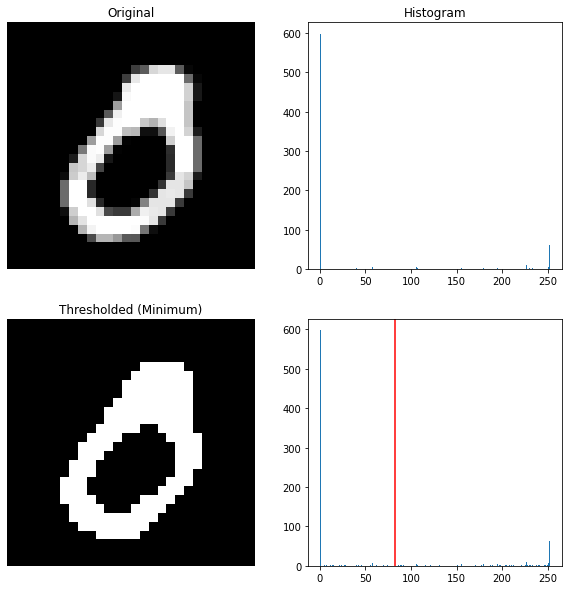

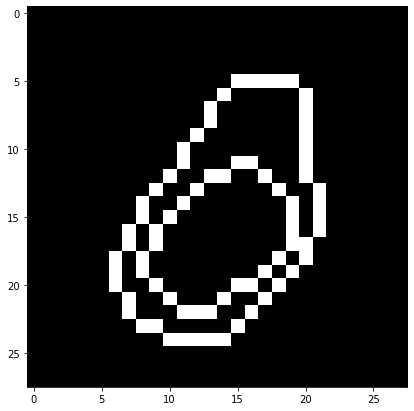

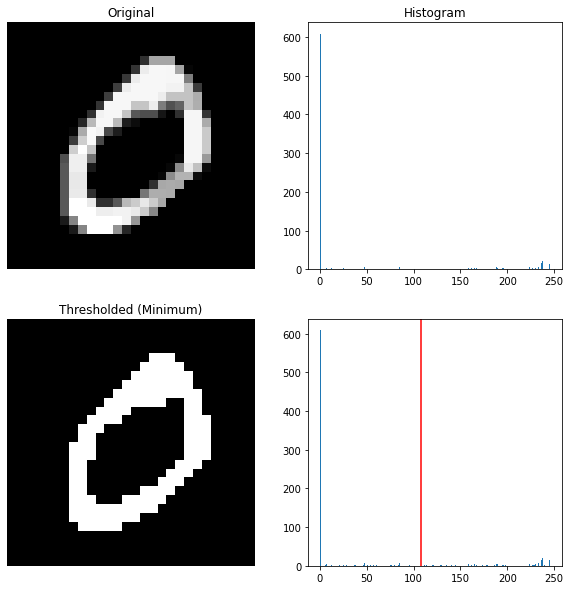

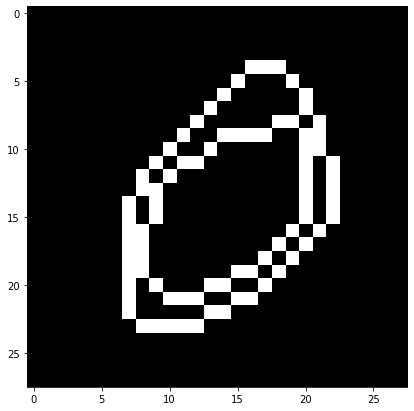

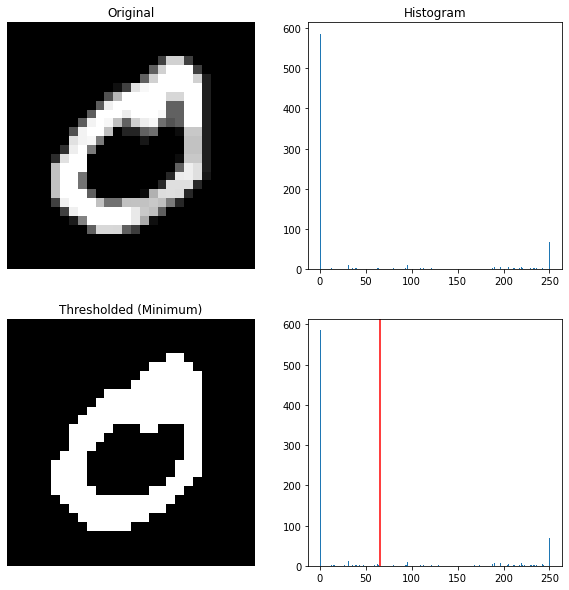

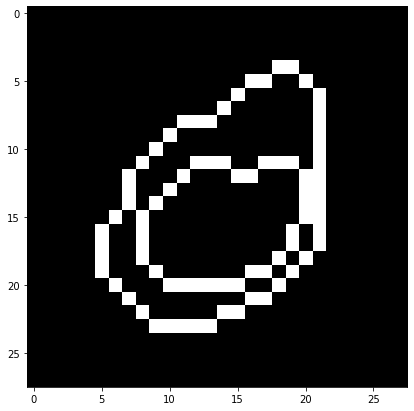

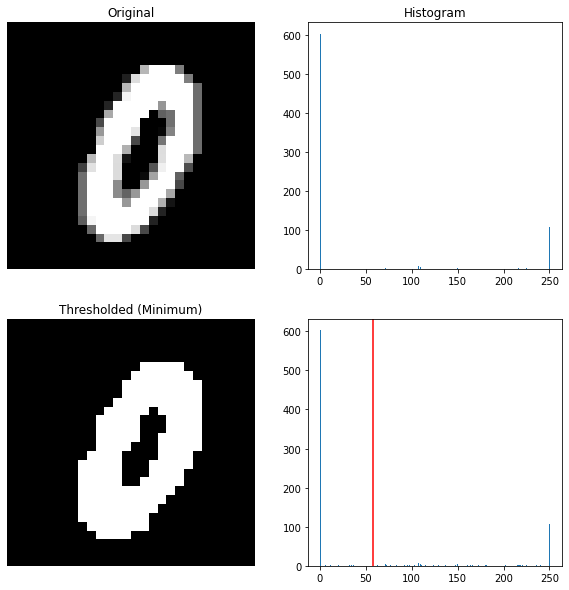

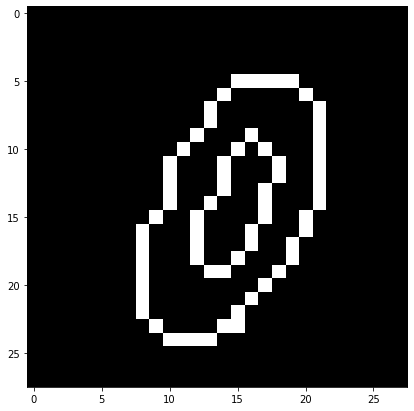

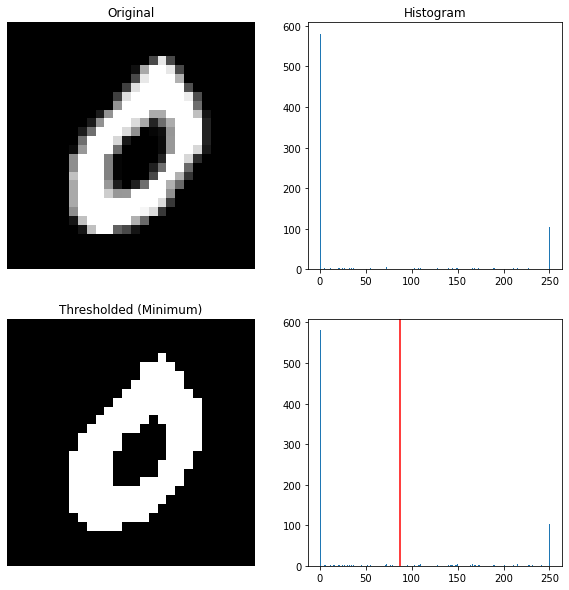

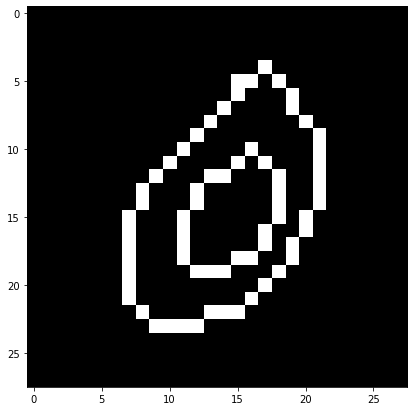

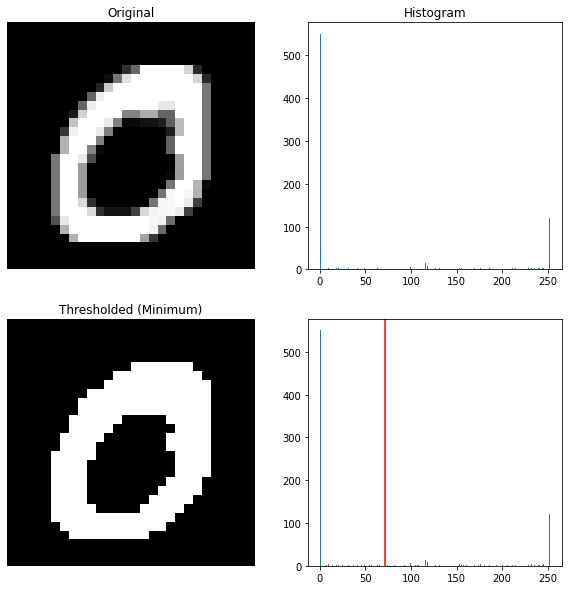

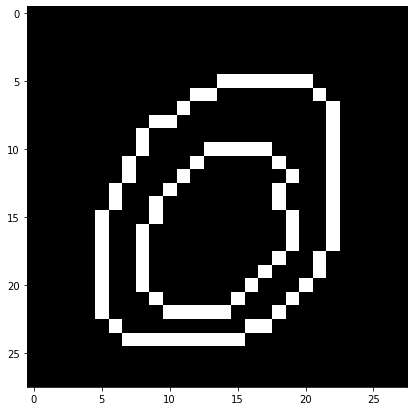

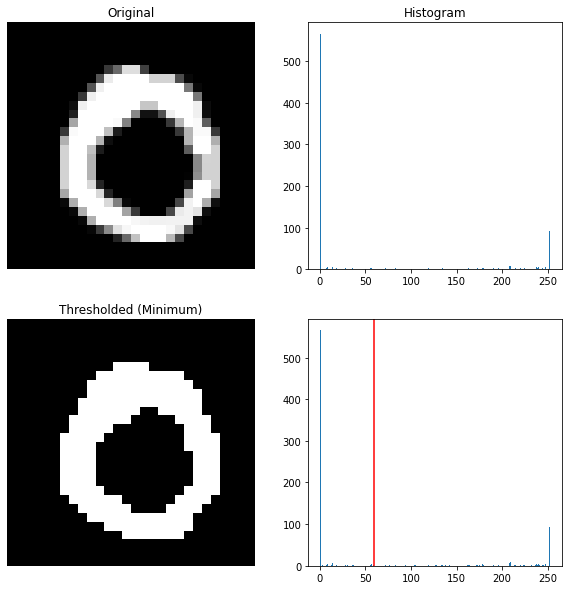

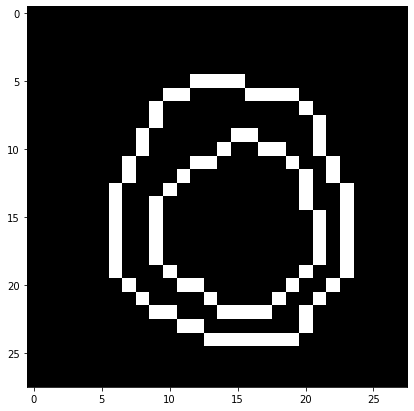

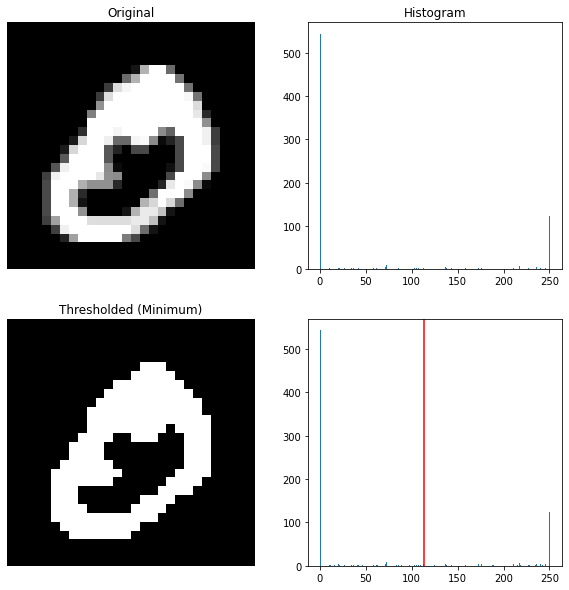

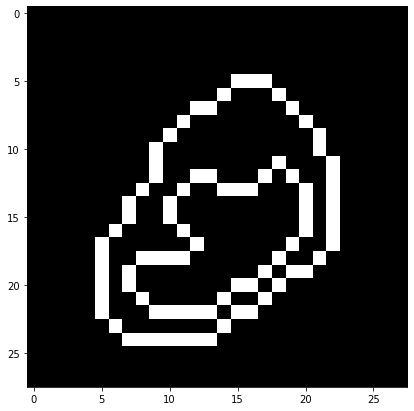

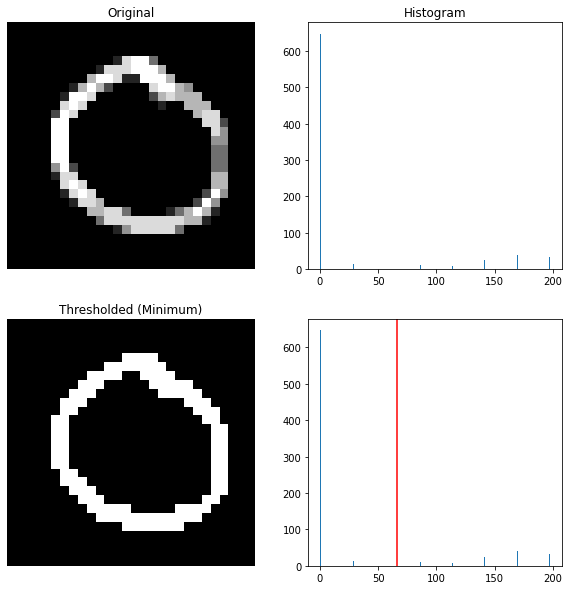

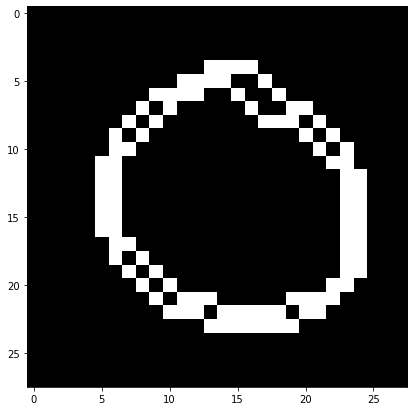

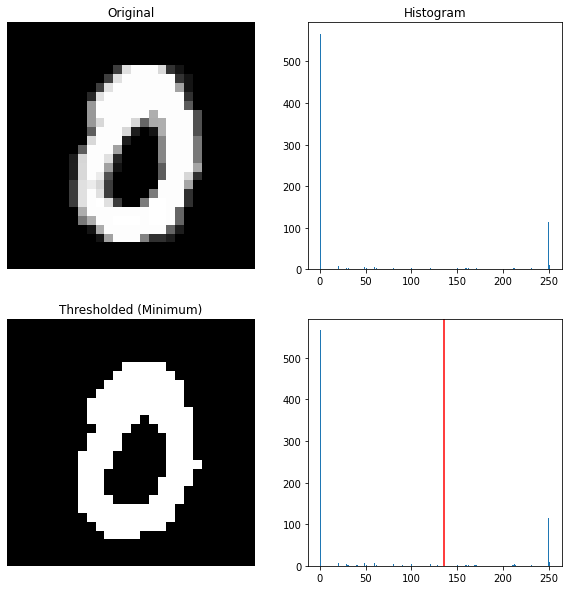

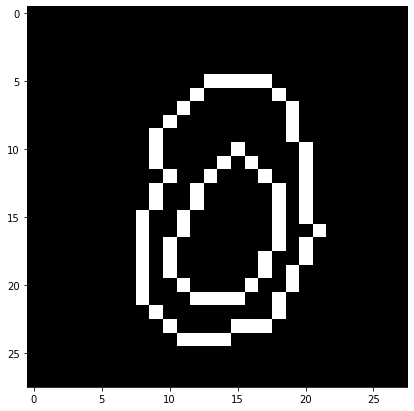

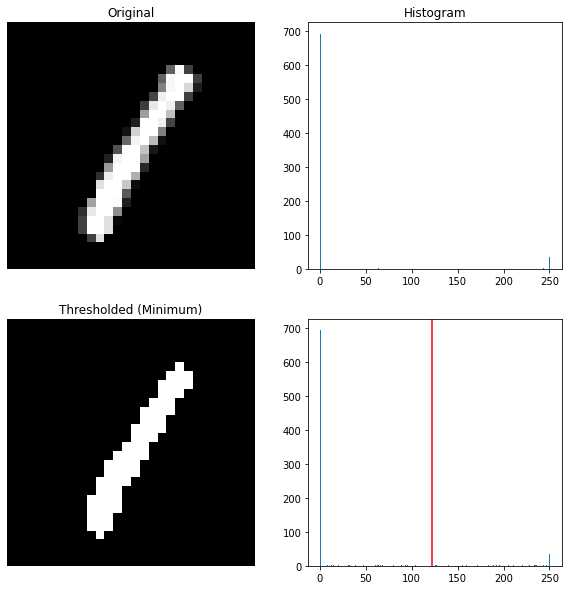

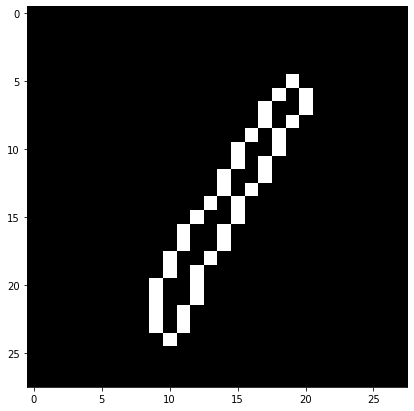

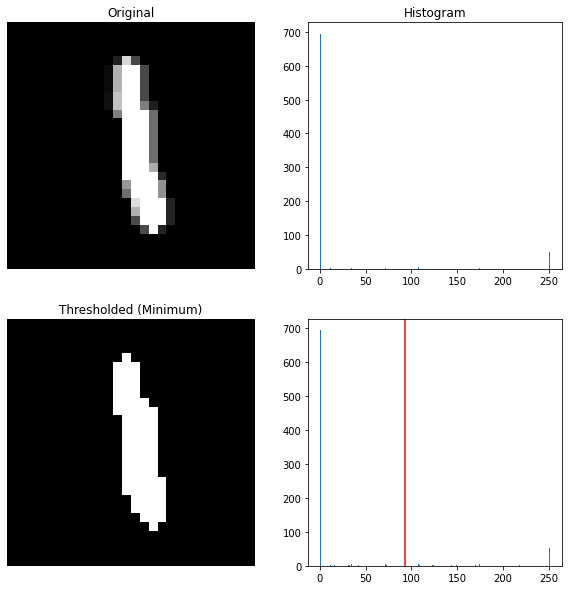

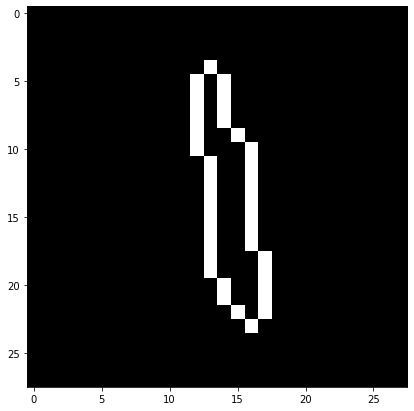

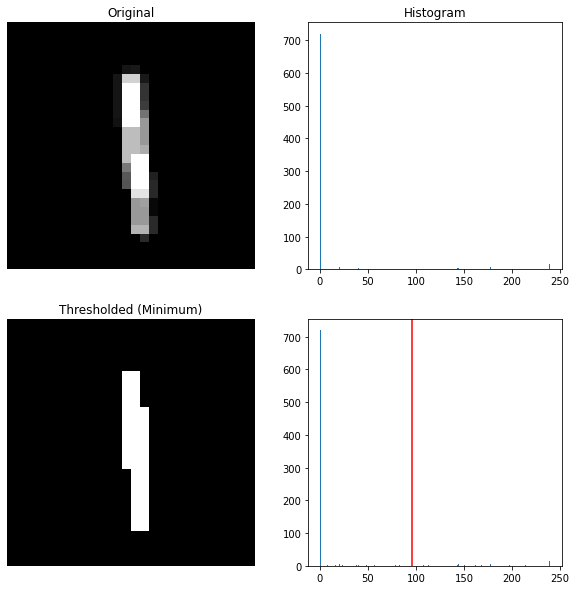

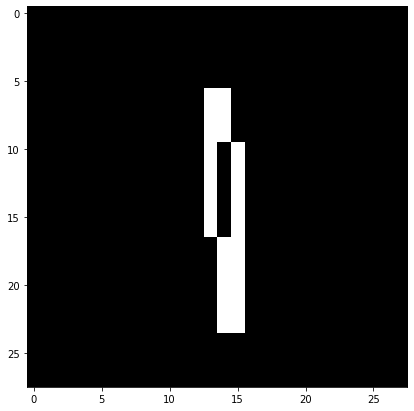

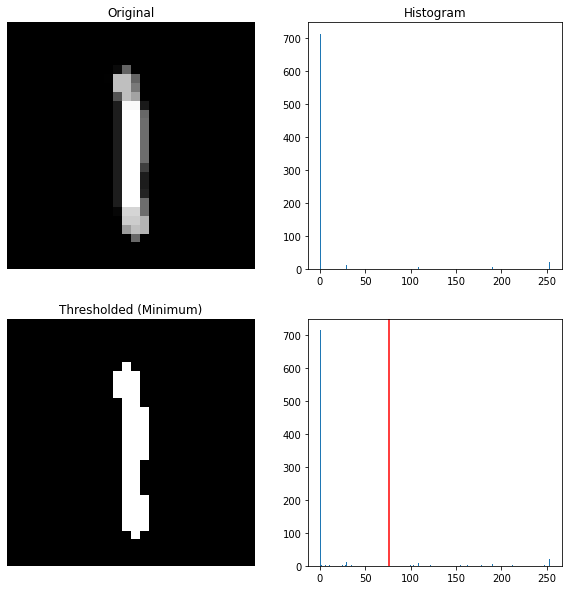

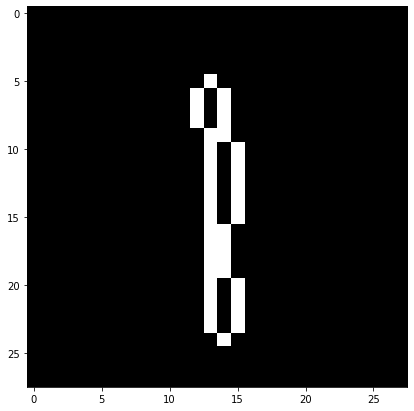

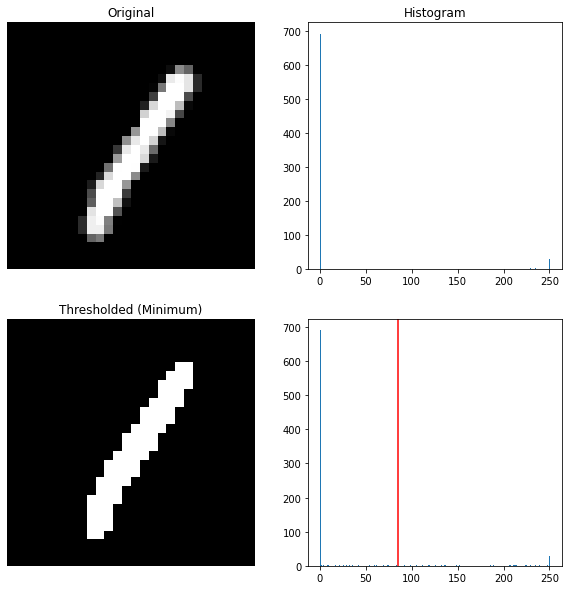

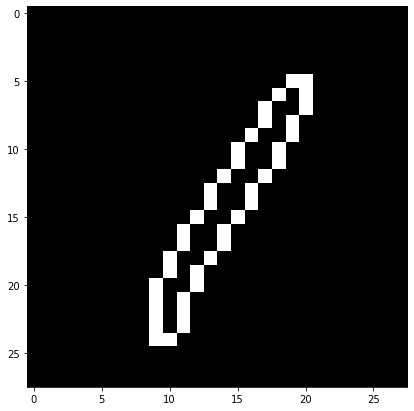

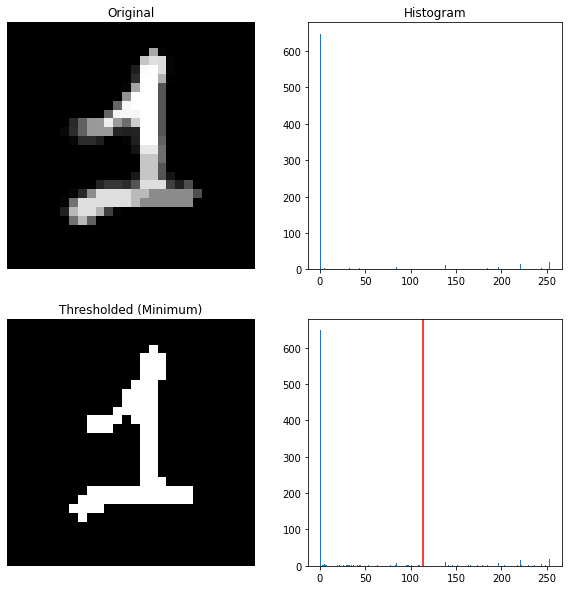

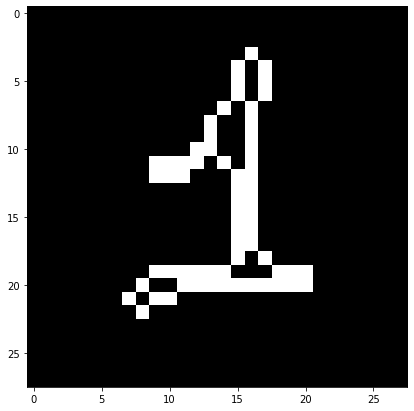

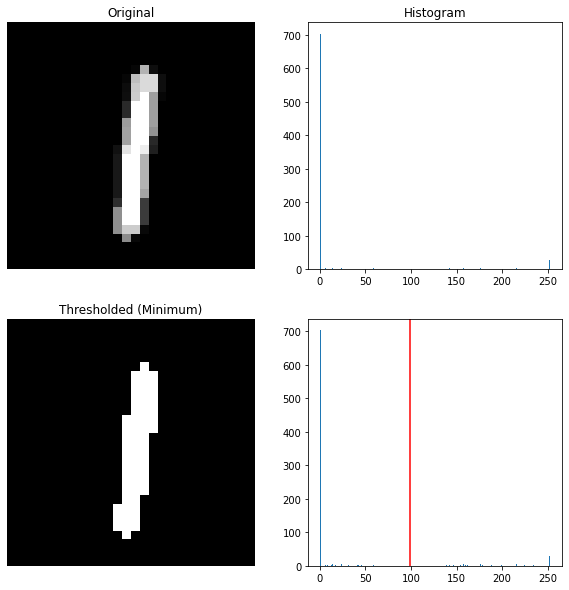

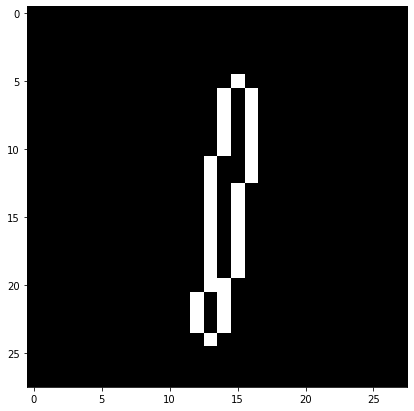

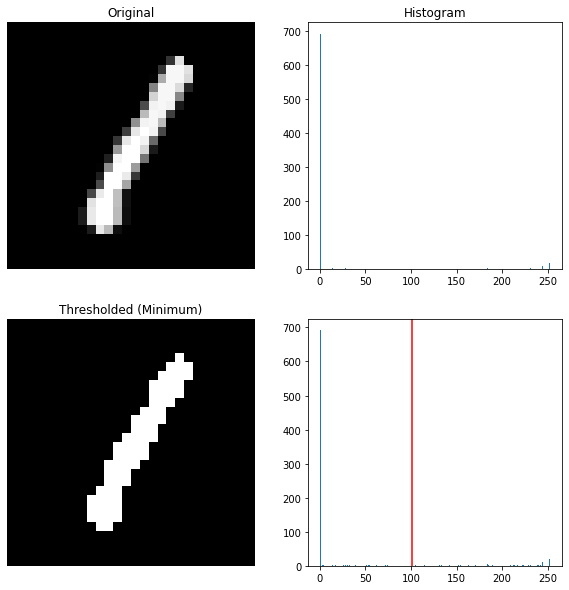

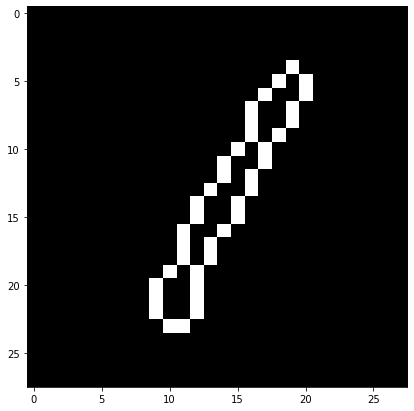

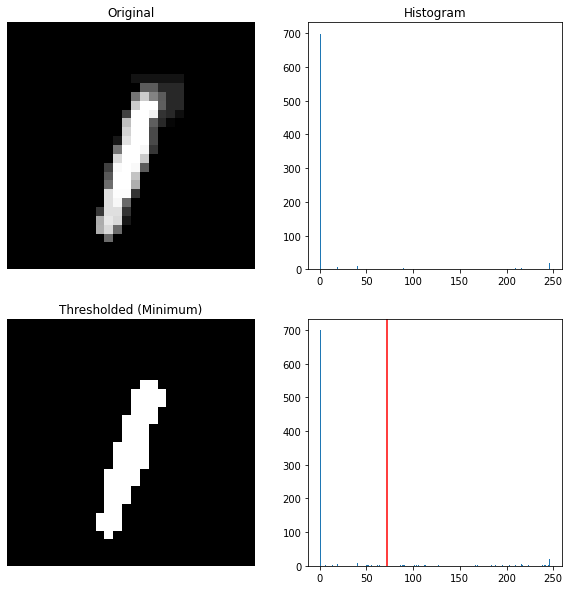

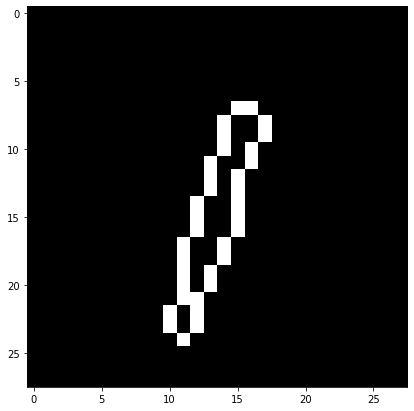

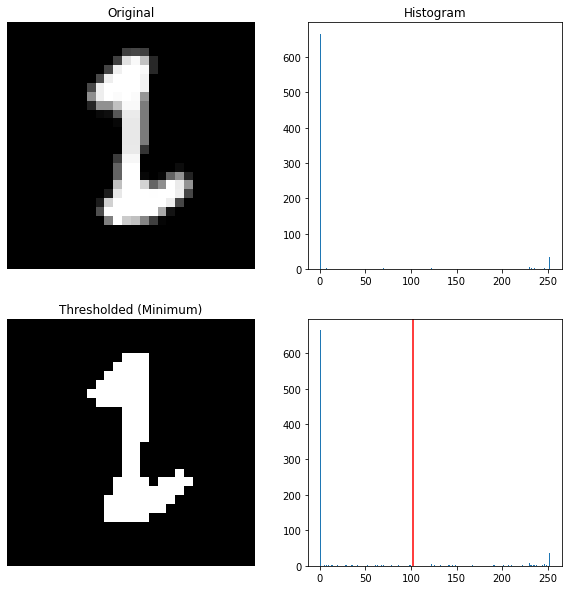

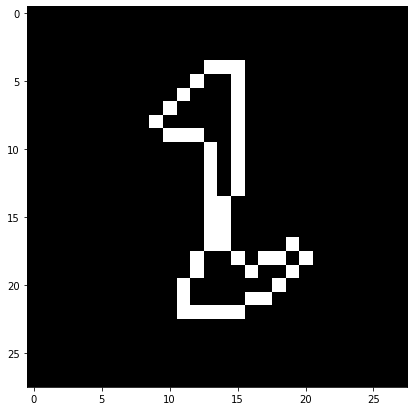

In [18]:
single_pixel_contour_0 = find_single_pixel_contour(zeros_im)

single_pixel_contour_1 = find_single_pixel_contour(ones_im)     

For what concerns the following steps of the algorithm, there is another aspect that we have to consider. The contours that have been identified thanks to the function 'find_single_pixel_contour' and that have been stored in 'single_pixel_contour_0' and 'single_pixel_contour_1' may be of different sizes, and therefore the identified contours may be of different lengths. However, since we need the same frequencies to represent the FFT of the various digits, the number of points should be the same for all digits. To do so, we can consider the digit that has a contour described by the highest amount of points and use linear interpolation to resample all the other signals so that they are described on the same amount of points. As the variables are independent, we can perform the interpolation before creating the complex number and interpolating on x and y separately. As we have to perform this additional step, we decided to modify a bit the code implemented for the single digit, splitting it into two functions.

The first function, 'visit_contour', starts from a series of single-pixel contours and visits them in order, returning the lists containing the x-coordinates and the y-coordinates, visited in order, of the corresponding single-pixel contours. The function also returns 'max_len', which indicates the length of the contour with the maximum length.

The second function, 'find_descriptors', starting from the lists containing the x-coordinates and the y-coordinates of the contours, returns two Fourier descriptors for each contour. The two parameters 'pos_descr_1' and 'pos_descr_2', requested as input of the function, indicates which Fourier descriptors should be returned. Note that, as we decided to use the component in position 0 (that is, the first one after removing the zero frequency/DC component) to perform rescaling, 'pos_descr_1' and 'pos_descr_2' should assume values greater than one or equal to one. Furthermore, they must be the same across different digits.

In [19]:
from scipy import interpolate

def find_start(img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if (img[i, j] == 1):
                # First point found
                return i,j
    # No point found
    return -1,-1


def visit_contour(single_pixel_contour):
    list_x_all = [ []*len(single_pixel_contour) for i in range(len(single_pixel_contour))]
    list_y_all = [ []*len(single_pixel_contour) for i in range(len(single_pixel_contour))]
    max_len = -1
    
    for img_index in range(len(single_pixel_contour)):
        new = single_pixel_contour[img_index]
        start_i, start_j = find_start(new)
        finish = 0
        contour = np.zeros((new.shape[0], new.shape[1]))
        contour[start_i, start_j] = 1
        i = start_i
        j = start_j
        pos_available = np.zeros(8) # Starts from h12 in a clock 
        pos_order = [0, 1, 2, 3, 4, 5, 6, 7] # Starts from h12 in a clock
        list_x = []
        list_y = []
        
        while (finish == 0):
            pos_available = [0, 0, 0, 0, 0, 0, 0, 0]
            pos_hyp_available = [0, 0, 0, 0, 0, 0, 0, 0]
            if (new[i-1, j] == 1 and contour[i-1, j] == 0):
                pos_available[0] = 1
            if (new[i-1, j+1] == 1 and contour[i-1, j+1] == 0):
                pos_available[1] = 1
            if (new[i, j+1] == 1 and contour[i, j+1] == 0):
                pos_available[2] = 1
            if (new[i+1, j+1] == 1 and contour[i+1, j+1] == 0):
                pos_available[3] = 1
            if (new[i+1, j] == 1 and contour[i+1, j] == 0):
                pos_available[4] = 1
            if (new[i+1, j-1] == 1 and contour[i+1, j-1] == 0):
                pos_available[5] = 1
            if (new[i, j-1] == 1 and contour[i, j-1] == 0):
                pos_available[6] = 1
            if (new[i-1, j-1] == 1 and contour[i-1, j-1] == 0):
                pos_available[7] = 1
            if (new[i-1, j]):
                pos_hyp_available[0] = 1
            if (new[i-1, j+1]):
                pos_hyp_available[1] = 1
            if (new[i, j+1] == 1):
                pos_hyp_available[2] = 1
            if (new[i+1, j+1] == 1):
                pos_hyp_available[3] = 1
            if (new[i+1, j] == 1):
                pos_hyp_available[4] = 1
            if (new[i+1, j-1] == 1):
                pos_hyp_available[5] = 1
            if (new[i, j-1] == 1):
                pos_hyp_available[6] = 1
            if (new[i-1, j-1] == 1):
                pos_hyp_available[7] = 1
                
            ind = np.argsort(pos_order)

            chosen = 0
            for index in ind:
                if (pos_available[index] == 1 and chosen == 0):
                    chosen_ind = index
                    chosen = 1
            if (chosen == 0):
                finish = 1
        
            chosen = 0
            for index in ind:
                if (pos_hyp_available[index] == 1 and chosen == 0):
                    chosen_hyp_ind = index
                    chosen = 1
            if (chosen == 0):
                finish = 1
                
            if chosen_hyp_ind == 0: # Going up
                if (i-1 == start_i and j == start_j):
                    finish = 1
            if chosen_hyp_ind == 1: # Going up-right
                if (i-1 == start_i and j+1 == start_j):
                    finish = 1
            if chosen_hyp_ind == 2: # Going right
                if (i == start_i and j+1 == start_j):
                    finish = 1
            if chosen_hyp_ind == 3: # Going down-right
                if (i+1 == start_i and j+1 == start_j):
                    finish = 1
            if chosen_hyp_ind == 4: # Going down
                if (i+1 == start_i and j == start_j):
                    finish = 1
            if chosen_hyp_ind == 5: # Going down-left
                if (i+1 == start_i and j-1 == start_j):
                    finish = 1
            if chosen_hyp_ind == 6: # Going left
                if (i == start_i and j-1 == start_j):
                    finish = 1
            if chosen_hyp_ind == 7: # Going up-left
                if (i-1 == start_i and j-1 == start_j):
                    finish = 1
                    
            if chosen_ind == 0 and finish == 0: # Going up
                contour[i-1, j] = 1
                i = i-1
                j = j
                list_y = np.append(list_y, i)
                list_x = np.append(list_x, j)
                pos_order = [2, 3, 4, 5, 6, 7, 0, 1]
            if chosen_ind == 1 and finish == 0: # Going up-right
                contour[i-1, j+1] = 1
                i = i-1
                j = j+1
                list_y = np.append(list_y, i)
                list_x = np.append(list_x, j)
                pos_order = [1, 2, 3, 4, 5, 6, 7, 0]
            if chosen_ind == 2 and finish == 0: # Going right
                contour[i, j+1] = 1
                i = i
                j = j+1
                list_y = np.append(list_y, i)
                list_x = np.append(list_x, j)
                pos_order = [0, 1, 2, 3, 4, 5, 6, 7]
            if chosen_ind == 3 and finish == 0: # Going down-right
                contour[i+1, j+1] = 1
                i = i+1
                j = j+1
                list_y = np.append(list_y, i)
                list_x = np.append(list_x, j)
                pos_order = [7, 0, 1, 2, 3, 4, 5, 6]
            if chosen_ind == 4 and finish == 0: # Going down
                contour[i+1, j] = 1
                i = i+1
                j = j
                list_y = np.append(list_y, i)
                list_x = np.append(list_x, j)
                pos_order = [6, 7, 0, 1, 2, 3, 4, 5]
            if chosen_ind == 5 and finish == 0: # Going down-left
                contour[i+1, j-1] = 1
                i = i+1
                j = j-1
                list_y = np.append(list_y, i)
                list_x = np.append(list_x, j)
                pos_order = [5, 6, 7, 0, 1, 2, 3, 4]
            if chosen_ind == 6 and finish == 0: # Going left
                contour[i, j-1] = 1
                i = i
                j = j-1
                list_y = np.append(list_y, i)
                list_x = np.append(list_x, j)
                pos_order = [4, 5, 6, 7, 0, 1, 2, 3]
            if chosen_ind == 7 and finish == 0: # Going up-left
                contour[i-1, j-1] = 1
                i = i-1
                j = j-1
                list_y = np.append(list_y, i)
                list_x = np.append(list_x, j)
                pos_order = [3, 4, 5, 6, 7, 0, 1, 2]
        
        # Store the list of the x-coordinates in the list containing the lists of all the different digits
        list_x_all[img_index][:] = list_x
        # Store the list of the y-coordinates in the list containing the lists of all the different digits
        list_y_all[img_index][:] = list_y
        # Determine the maximum length across all the lists
        if len(list_x) > max_len:
            max_len = len(list_x)
            
    return list_x_all, list_y_all, max_len, len(single_pixel_contour)


def find_descriptors(list_x_all, list_y_all, overall_max_len, cycle_length, pos_descr_1, pos_descr_2, invariance=True):
    first_descriptor = []
    second_descriptor = []
    for img_index in range(cycle_length):
        # Perform linear interpolation
        f_x = interpolate.interp1d(x = range(len(list_x_all[img_index])), y = list_x_all[img_index][:])
        # Obtain the new sample locations so that we have the same number of samples across all digits
        x_new = np.linspace(0, len(list_x_all[img_index])-1, overall_max_len)
        # Re-sample the signal
        f_x_new = f_x(x_new)
        # Update the list containing the x-coordinate of the visited points of the contours
        list_x_all[img_index] = f_x_new
        
        # Perform linear interpolation
        f_y = interpolate.interp1d(x = range(len(list_y_all[img_index])), y = list_y_all[img_index][:])
        # Obtain the new sample locations so that we have the same number of samples across all digits
        y_new = np.linspace(0, len(list_y_all[img_index])-1, overall_max_len)
        # Re-sample the signal
        f_y_new = f_y(y_new)
        # Update the list containing the y-coordinate of the visited points of the contours
        list_y_all[img_index] = f_y_new
        
        list_u = np.asarray(list_x_all[img_index][:]) + 1j*np.asarray(list_y_all[img_index][:])
        
        f_l = np.fft.fft(list_u) # DFT of the list of points
        
        if invariance:
            f_l = f_l[1:] # Invariance to translation

            f_l_amplitude = np.abs(f_l) # Invariance to rotation

            f_l_normalized = f_l_amplitude / f_l_amplitude[0] # Invariance to scaling
        else:
            f_l = f_l[1:] # Invariance to translation
            
            f_l_amplitude = np.abs(f_l) # Invariance to rotation
            
            f_l_normalized = f_l_amplitude # NO invariance to scaling

        first_descriptor.append(f_l_normalized[pos_descr_1])
        second_descriptor.append(f_l_normalized[pos_descr_2])
        
    return first_descriptor, second_descriptor

At this point, we apply the function 'visit_contour' to the single-pixel wide contours stored in 'single_pixel_contour_0' and 'single_pixel_contour_1'. After applying 'find_descriptors', we obtain the corresponding two Fourier descriptors for each contour.

In order to obtain a nice separation between the different classes of digits, we may decide which Fourier descriptors to plot, keeping into account that the first components are related to low frequencies and that the last components are related to high frequencies. In the following, we will consider the first and the second Fourier descriptors in a plot and the second and the fourth Fourier descriptors in a second plot. Note that, when indicating which descriptors to use, we consider as first Fourier descriptor the first one after the one used for renormalization, which in turn is the first one after the zero frequency/DC component.

In the plots below, the descriptors associated with the digits '0' are plotted in blue, the descriptors associated with the digits '1' are plotted in red.

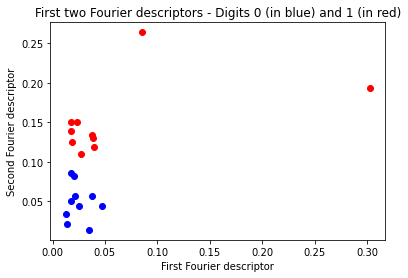

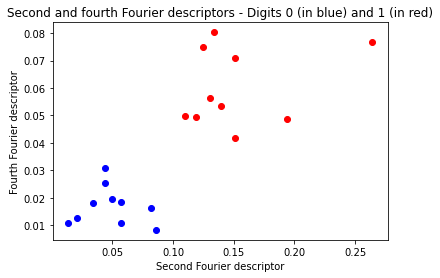

In [20]:
list_x_all_0, list_y_all_0, max_len_0, cycle_length_0 = visit_contour(single_pixel_contour_0)
list_x_all_1, list_y_all_1, max_len_1, cycle_length_1 = visit_contour(single_pixel_contour_1)

max_len = max(max_len_0, max_len_1)

first_descriptor_0, second_descriptor_0 = find_descriptors(list_x_all_0, list_y_all_0, max_len, cycle_length_0, 1, 2)
first_descriptor_1, second_descriptor_1 = find_descriptors(list_x_all_1, list_y_all_1, max_len, cycle_length_1, 1, 2)

# Plot of the first and the second Fourier descriptors

plt.title("First two Fourier descriptors - Digits 0 (in blue) and 1 (in red)") 
plt.xlabel("First Fourier descriptor") 
plt.ylabel("Second Fourier descriptor") 
plt.plot(first_descriptor_0, second_descriptor_0, 'ob', first_descriptor_1, second_descriptor_1, 'or') 
plt.show()


first_descriptor_0, second_descriptor_0 = find_descriptors(list_x_all_0, list_y_all_0, max_len, cycle_length_0, 2, 4)
first_descriptor_1, second_descriptor_1 = find_descriptors(list_x_all_1, list_y_all_1, max_len, cycle_length_1, 2, 4)

# Plot of the second and the fourth Fourier descriptors

plt.title("Second and fourth Fourier descriptors - Digits 0 (in blue) and 1 (in red)") 
plt.xlabel("Second Fourier descriptor") 
plt.ylabel("Fourth Fourier descriptor") 
plt.plot(first_descriptor_0, second_descriptor_0, 'ob', first_descriptor_1, second_descriptor_1, 'or') 
plt.show()

We can see that, in both cases, the digits are nicely clustered and can be easily separated using a line. A linear classifier will be, therefore, enough to classify the digits. In the first plot, which considers the first and the second Fourier descriptors, it is possible to see that, while the first Fourier descriptor is not well suited to distinguish the classes, the second descriptor allows to obtain excellent results. Indeed, it would be possible to use the second Fourier descriptor alone for classification.

Since the first Fourier descriptor is not very suited for the task, we have decided to keep the second Fourier descriptor and consider the fourth one, which allows for obtaining nice clusters, good separation and a significant margin between the two classes. The feature chosen seems, therefore, to be adequate.

### Proof of invariance

We now prove the invariance of the descriptors with respect to rotation, translation, scaling up and scaling down. The proof will be done in 2 ways: first, graphically, then numerically.

In [21]:
#Invariance proof
#Complete procedure to be applied
def full_descriptors(imgs_0, imgs_1, plot_bool=True, invariance=True):
    single_pixel_contour_0 = find_single_pixel_contour(imgs_0, False)
    list_x_all_0, list_y_all_0, max_len_0, cycle_length_0 = visit_contour(single_pixel_contour_0)
    
    single_pixel_contour_1 = find_single_pixel_contour(imgs_1, False)
    list_x_all_1, list_y_all_1, max_len_1, cycle_length_1 = visit_contour(single_pixel_contour_1)
    
    max_len = max(max_len_0, max_len_1)

    first_descriptor_0, second_descriptor_0 = find_descriptors(list_x_all_0, list_y_all_0, max_len, cycle_length_0, 1, 2, invariance)
    first_descriptor_1, second_descriptor_1 = find_descriptors(list_x_all_1, list_y_all_1, max_len, cycle_length_1, 1, 2, invariance)
    
    if plot_bool:
        plt.title("First two Fourier descriptors - Digits 0 (in blue) and 1 (in red)") 
        plt.xlabel("First Fourier descriptor") 
        plt.ylabel("Second Fourier descriptor") 
        plt.plot(first_descriptor_0, second_descriptor_0, 'ob', first_descriptor_1, second_descriptor_1, 'or') 
        plt.show()

    second_descriptor_0, fourth_descriptor_0 = find_descriptors(list_x_all_0, list_y_all_0, max_len, cycle_length_0, 2, 4, invariance)
    second_descriptor_1, fourth_descriptor_1 = find_descriptors(list_x_all_1, list_y_all_1, max_len, cycle_length_1, 2, 4, invariance)

    # Plot of the second and the fourth Fourier descriptors
    if plot_bool:
        plt.title("Second and fourth Fourier descriptors - Digits 0 (in blue) and 1 (in red)") 
        plt.xlabel("Second Fourier descriptor") 
        plt.ylabel("Fourth Fourier descriptor") 
        plt.plot(second_descriptor_0, fourth_descriptor_0, 'ob', second_descriptor_1, fourth_descriptor_1, 'or') 
        plt.show()
    
    first_2_descr_0 = (first_descriptor_0, second_descriptor_0)
    first_2_descr_1 = (first_descriptor_1, second_descriptor_1)
    
    second_2_descr_0 = (second_descriptor_0, fourth_descriptor_0)
    second_2_descr_1 = (second_descriptor_0, fourth_descriptor_1)
    
    
    
    
    return first_2_descr_0, first_2_descr_1, second_2_descr_0, second_2_descr_1
    
    

#### Rotation

We chose to rotate the images of 90 degrees, as shown below.

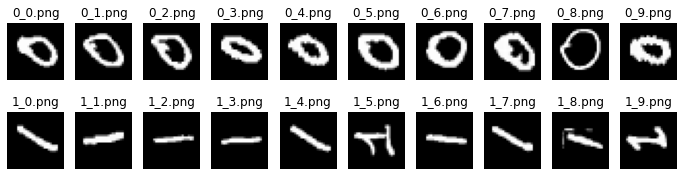

In [22]:
#Rotation
from skimage.transform import rotate
#originals: zeros_im, ones_im   

zeros_im_rotated = zeros_im.copy()
ones_im_rotated = ones_im.copy()

assert len(zeros_im_rotated) == len(ones_im_rotated)

for ind, img in enumerate(zeros_im_rotated):
    zeros_im_rotated[ind] = rotate(img, angle=90, preserve_range=True)
    img_one = ones_im_rotated[ind]
    ones_im_rotated[ind] = rotate(img_one, angle=90, preserve_range=True)
    
plot_grid(zeros_im_rotated, zeros_names, ones_im_rotated, ones_names)

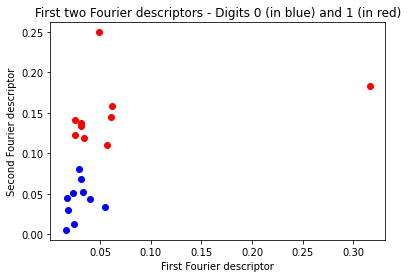

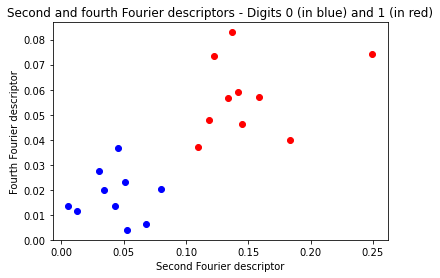

In [23]:
rot_first_2_descr_0, rot_first_2_descr_1, rot_second_2_descr_0, rot_second_2_descr_1 = full_descriptors(zeros_im_rotated, ones_im_rotated)

As can be seen, the datapoints are linearly separable and the clusters are well identified. To verify mathematically as well, we first save the descriptors for the non-rotated images, then we compute the difference in absolute value.

In [24]:
original_first_2_descr_0, original_first_2_descr_1, original_second_2_descr_0, original_second_2_descr_1 = full_descriptors(zeros_im, ones_im, False)

In [25]:
words_list = ["first", "second", "third", "fourth"]
original_descriptors_0 = []
original_descriptors_1 = []
for i in range(2):
    original_descriptors_0.append(original_first_2_descr_0[i])
    original_descriptors_1.append(original_first_2_descr_1[i])
    
for i in range(2):
    original_descriptors_0.append(original_second_2_descr_0[i])
    original_descriptors_1.append(original_second_2_descr_1[i])


def compare_descriptors(mod_first_2_descr_0, mod_first_2_descr_1, mod_second_2_descr_0, mod_second_2_descr_1):
    mod_descriptors_0 = []
    mod_descriptors_1 = []
    for i in range(2):
        mod_descriptors_0.append(mod_first_2_descr_0[i])
        mod_descriptors_1.append(mod_first_2_descr_1[i])
    
    for i in range(2):
        mod_descriptors_0.append(mod_second_2_descr_0[i])
        mod_descriptors_1.append(mod_second_2_descr_1[i])
    
    
    print("Descriptors comparison\n")
    print("Zeros")
    for img in range(10):
        for descr in range(4):
            if descr != 2:
                diff = np.abs(original_descriptors_0[descr][img] - mod_descriptors_0[descr][img])
                print(f"Img {img}, {words_list[descr]} descriptor absolute difference: {diff}")
            
    print("\n")
    print("Ones")
    for img in range(10):
        for descr in range(4):
            if descr != 2:
                diff = np.abs(original_descriptors_1[descr][img] - mod_descriptors_1[descr][img])
                print(f"Img {img}, {words_list[descr]} descriptor absolute difference: {diff}")


compare_descriptors(rot_first_2_descr_0, rot_first_2_descr_1, rot_second_2_descr_0, rot_second_2_descr_1)

Descriptors comparison

Zeros
Img 0, first descriptor absolute difference: 0.018388747126706205
Img 0, second descriptor absolute difference: 0.013789576017427377
Img 0, fourth descriptor absolute difference: 0.0050666117111975734
Img 1, first descriptor absolute difference: 0.007988861974906732
Img 1, second descriptor absolute difference: 0.009872832344005676
Img 1, fourth descriptor absolute difference: 0.00519270167561536
Img 2, first descriptor absolute difference: 0.00827946126702753
Img 2, second descriptor absolute difference: 0.0017818076266024954
Img 2, fourth descriptor absolute difference: 0.005621776817327784
Img 3, first descriptor absolute difference: 0.008117284975776833
Img 3, second descriptor absolute difference: 0.0016521811862689056
Img 3, fourth descriptor absolute difference: 0.0041633499434976
Img 4, first descriptor absolute difference: 0.005389837447471596
Img 4, second descriptor absolute difference: 0.0007636454443622764
Img 4, fourth descriptor absolute dif

The perfect descriptor for the rotated images should have 0 difference with respect to the original one. In most cases, the difference is low, so we consider this result satisfactory.

#### Translation

We now verify invariance to translation. To move the shapes while not allowing them to go out of the borders of the picture, we apply a translation of a 15th of the height and of the width towards the right hand side, bottom corner.

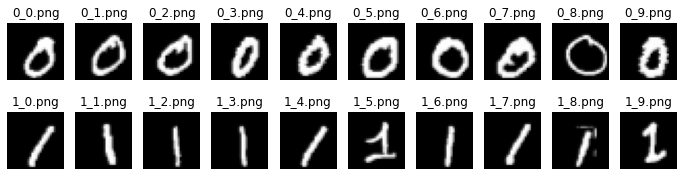

In [26]:
#Translation
import cv2
image = ones_im[0]
  
#Store height and width of the image
height, width = image.shape[:2]
  
reduction_height, reduction_width = height / 15, width / 15
  
T = np.float32([[1, 0, reduction_width], [0, 1, reduction_height]])
  
# We use warpAffine to transform the image using the matrix, T



zeros_im_translated = zeros_im.copy()
ones_im_translated = ones_im.copy()

assert len(zeros_im_translated) == len(ones_im_translated)

for ind, img in enumerate(zeros_im):
    zero_img_sc = cv2.warpAffine(img, T, (width, height))
    zeros_im_translated[ind] = zero_img_sc
    
    img_one = ones_im[ind]
    one_img_sc = cv2.warpAffine(img_one, T, (width, height))
    ones_im_translated[ind] = one_img_sc
    
plot_grid(zeros_im_translated, zeros_names, ones_im_translated, ones_names)

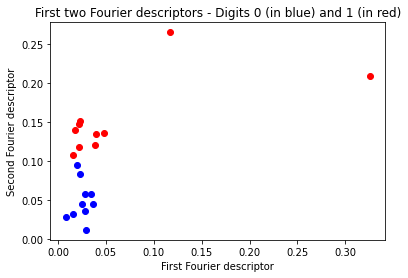

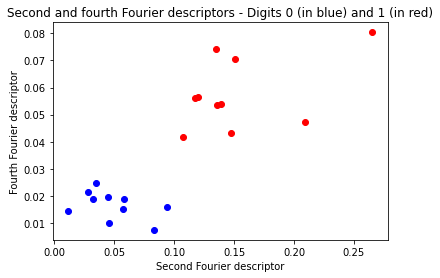

In [27]:
trasl_first_2_descr_0, trasl_first_2_descr_1, trasl_second_2_descr_0, trasl_second_2_descr_1 = full_descriptors(zeros_im_translated, ones_im_translated)

Again, we can see clearly that the points are linearly separable so the descriptors are invariant to translation. Now we check again also mathematically that the differences between the original predictors and these ones are low.

In [28]:
compare_descriptors(trasl_first_2_descr_0, trasl_first_2_descr_1,trasl_second_2_descr_0,trasl_second_2_descr_1)

Descriptors comparison

Zeros
Img 0, first descriptor absolute difference: 0.007176588501241889
Img 0, second descriptor absolute difference: 3.822149927557028e-06
Img 0, fourth descriptor absolute difference: 0.0033943373392397724
Img 1, first descriptor absolute difference: 0.009814954256502341
Img 1, second descriptor absolute difference: 0.0011691765124973788
Img 1, fourth descriptor absolute difference: 0.005700904019330339
Img 2, first descriptor absolute difference: 0.0024121802589486714
Img 2, second descriptor absolute difference: 0.008483551910319749
Img 2, fourth descriptor absolute difference: 0.005955360127985546
Img 3, first descriptor absolute difference: 0.0005745341950903343
Img 3, second descriptor absolute difference: 0.01224120707756847
Img 3, fourth descriptor absolute difference: 0.0003467887371018698
Img 4, first descriptor absolute difference: 0.016581968108864014
Img 4, second descriptor absolute difference: 0.007861618061285935
Img 4, fourth descriptor absolut

As we can see, also from the absolute value of the predictors we can see that the differences are small.

#### Scaling

For scaling, we have to consider two different cases: when the shapes become bigger and when they become smaller. Let's start from the latter, done by adding a padding around the image.


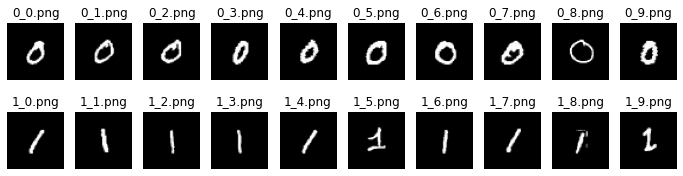

In [29]:
#Scaling down

pad = 10
zeros_im_scale_d = np.zeros((10, 28+2*pad, 28+2*pad))
ones_im_scale_d = np.zeros((10, 28+2*pad, 28+2*pad))

assert len(zeros_im_scale_d) == len(ones_im_scale_d)

for ind, img in enumerate(zeros_im):
    zero_img_sc = cv2.copyMakeBorder(img.copy(), pad,pad,pad,pad, cv2.BORDER_CONSTANT)
    zeros_im_scale_d[ind] = zero_img_sc
    
    img_one = ones_im[ind]
    one_img_sc = cv2.copyMakeBorder(img_one.copy(), pad,pad,pad,pad, cv2.BORDER_CONSTANT)
    ones_im_scale_d[ind] = one_img_sc
    
plot_grid(zeros_im_scale_d, zeros_names, ones_im_scale_d, ones_names)




We now resize the pictures in order to make them of the same dimension as the images we used until now.

In [30]:
zeros_im_scale_d_resized = np.zeros((10, 28, 28))
ones_im_scale_d_resized = np.zeros((10, 28, 28))
dim = (28, 28)

for i in range(len(zeros_im_scale_d)):
    zeros_im_scale_d_resized[i] = cv2.resize(zeros_im_scale_d[i], dim, interpolation = cv2.INTER_AREA)
    ones_im_scale_d_resized[i] = cv2.resize(ones_im_scale_d[i], dim, interpolation = cv2.INTER_AREA)

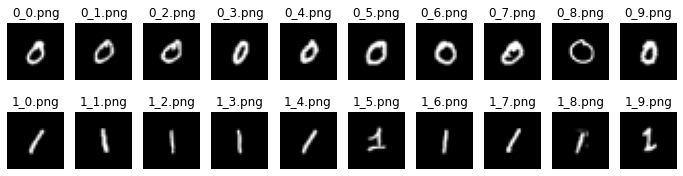

In [31]:
plot_grid(zeros_im_scale_d_resized, zeros_names, ones_im_scale_d_resized, ones_names)

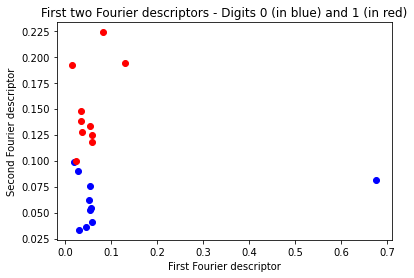

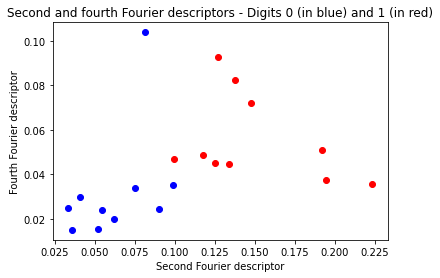

In [32]:
scale_d_first_2_descr_0, scale_d_first_2_descr_1, scale_d_second_2_descr_0, scale_d_second_2_descr_1 = full_descriptors(zeros_im_scale_d_resized, ones_im_scale_d_resized)

Once again, the two clusters are well defined and separated.

In [33]:
compare_descriptors(scale_d_first_2_descr_0, scale_d_first_2_descr_1, scale_d_second_2_descr_0, scale_d_second_2_descr_1)

Descriptors comparison

Zeros
Img 0, first descriptor absolute difference: 0.03159999018972102
Img 0, second descriptor absolute difference: 0.00509399653002187
Img 0, fourth descriptor absolute difference: 0.001522998741736309
Img 1, first descriptor absolute difference: 0.008548493125598494
Img 1, second descriptor absolute difference: 0.01083327189916225
Img 1, fourth descriptor absolute difference: 0.0012299246927707785
Img 2, first descriptor absolute difference: 0.03293670293267889
Img 2, second descriptor absolute difference: 0.002670693251448475
Img 2, fourth descriptor absolute difference: 0.0012943809162074618
Img 3, first descriptor absolute difference: 0.0020897813232305072
Img 3, second descriptor absolute difference: 0.016858627740086826
Img 3, fourth descriptor absolute difference: 0.018949562339946928
Img 4, first descriptor absolute difference: 0.03625260366317605
Img 4, second descriptor absolute difference: 0.025093054979112392
Img 4, fourth descriptor absolute diffe

We now switch to the scaling up: we do the opposite of padding, by removing pixels of the borders

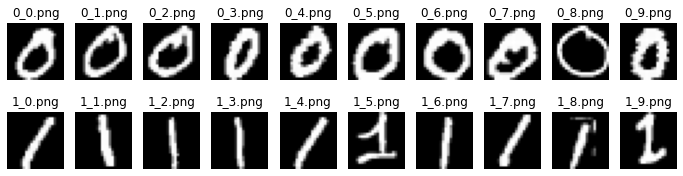

In [34]:
#Scaling up
pad = 3
zeros_im_scale_u = np.zeros((10, 28-2*pad, 28-2*pad))
ones_im_scale_u = np.zeros((10, 28-2*pad, 28-2*pad))

assert len(zeros_im_scale_u) == len(ones_im_scale_u)

for ind, img in enumerate(zeros_im):
    zero_img_sc = zeros_im[ind][3:-3, 3:-3]
    zeros_im_scale_u[ind] = zero_img_sc
    
    one_img_sc = ones_im[ind][3:-3, 3:-3]
    ones_im_scale_u[ind] = one_img_sc

    
plot_grid(zeros_im_scale_u, zeros_names, ones_im_scale_u, ones_names)


In [35]:
zeros_im_scale_u_resized = np.zeros((10, 28, 28))
ones_im_scale_u_resized = np.zeros((10, 28, 28))
dim = (28, 28)

for i in range(len(zeros_im_scale_d)):
    zeros_im_scale_u_resized[i] = cv2.resize(zeros_im_scale_u[i], dim, interpolation = cv2.INTER_AREA)
    ones_im_scale_u_resized[i] = cv2.resize(ones_im_scale_u[i], dim, interpolation = cv2.INTER_AREA)
    
    #we make the shapes not cross the border
    
    zeros_im_scale_u_resized[i][0] = np.zeros(28)
    zeros_im_scale_u_resized[i][-1] = np.zeros(28)
    zeros_im_scale_u_resized[i][0, :] = np.zeros(28)
    zeros_im_scale_u_resized[i][-1, :] = np.zeros(28)
    
    
    zeros_im_scale_u_resized[i][1] = np.zeros(28)
    zeros_im_scale_u_resized[i][-2] = np.zeros(28)
    zeros_im_scale_u_resized[i][1, :] = np.zeros(28)
    zeros_im_scale_u_resized[i][-2, :] = np.zeros(28)
    
    zeros_im_scale_u_resized[i][2] = np.zeros(28)
    zeros_im_scale_u_resized[i][-3] = np.zeros(28)
    zeros_im_scale_u_resized[i][2, :] = np.zeros(28)
    zeros_im_scale_u_resized[i][-3, :] = np.zeros(28)
    
    ones_im_scale_u_resized[i][0] = np.zeros(28)
    ones_im_scale_u_resized[i][-1] = np.zeros(28)
    ones_im_scale_u_resized[i][0, :] = np.zeros(28)
    ones_im_scale_u_resized[i][-1, :] = np.zeros(28)
    
    ones_im_scale_u_resized[i][1] = np.zeros(28)
    ones_im_scale_u_resized[i][-2] = np.zeros(28)
    ones_im_scale_u_resized[i][1, :] = np.zeros(28)
    ones_im_scale_u_resized[i][-2, :] = np.zeros(28)
    

    
    ones_im_scale_u_resized[i][2] = np.zeros(28)
    ones_im_scale_u_resized[i][-3] = np.zeros(28)
    ones_im_scale_u_resized[i][2, :] = np.zeros(28)
    ones_im_scale_u_resized[i][-3, :] = np.zeros(28)
    
    
    

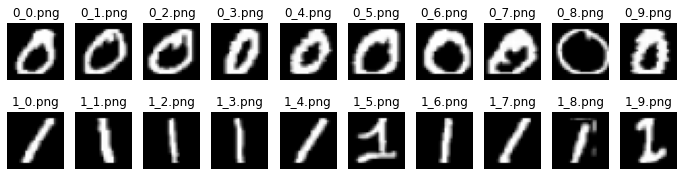

In [36]:
plot_grid(zeros_im_scale_u_resized, zeros_names, ones_im_scale_u_resized, ones_names)

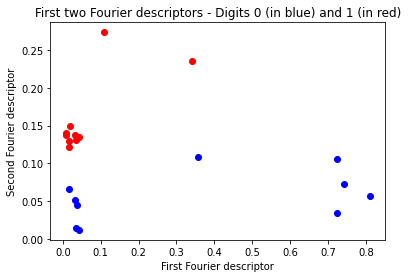

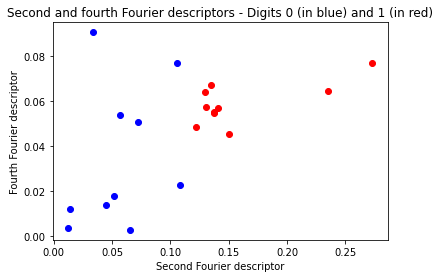

In [37]:
scale_u_first_2_descr_0, scale_u_first_2_descr_1, scale_u_second_2_descr_0, scale_u_second_2_descr_1 = full_descriptors(zeros_im_scale_u_resized, ones_im_scale_u_resized)

In [38]:
compare_descriptors(scale_u_first_2_descr_0, scale_u_first_2_descr_1, scale_u_second_2_descr_0, scale_u_second_2_descr_1)

Descriptors comparison

Zeros
Img 0, first descriptor absolute difference: 0.703178380485982
Img 0, second descriptor absolute difference: 0.022889600418361876
Img 0, fourth descriptor absolute difference: 0.07216668190039073
Img 1, first descriptor absolute difference: 0.004878955217494603
Img 1, second descriptor absolute difference: 0.03159734810031774
Img 1, fourth descriptor absolute difference: 0.022022471873335493
Img 2, first descriptor absolute difference: 0.010627523767463752
Img 2, second descriptor absolute difference: 0.029369240188871153
Img 2, fourth descriptor absolute difference: 0.018840957564779257
Img 3, first descriptor absolute difference: 0.0033831467870714636
Img 3, second descriptor absolute difference: 0.016334761320679445
Img 3, fourth descriptor absolute difference: 0.013630361416520438
Img 4, first descriptor absolute difference: 0.020226425537057193
Img 4, second descriptor absolute difference: 0.004904728226209139
Img 4, fourth descriptor absolute differe

Also in this case the clusters are linearly separable. The precision is a bit lower, maybe due to the resizing and the modification applied to avoid the numbers to hit the border of the image.

#### Without rescaling invariance conditions

As an additional proof, we now build the descriptors removing one of the invariance conditions; in particular, we remove the invariance to rescaling. The invariance to translation and the invariance to rotation are instead maintained. We then consider rotated, translated and rescaled digits, and we check whether the different digits are still separable and whether the results are similar to what has been observed with all the invariance conditions in place.

##### Rotation

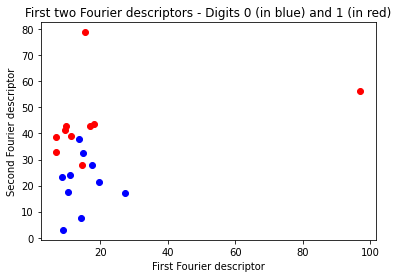

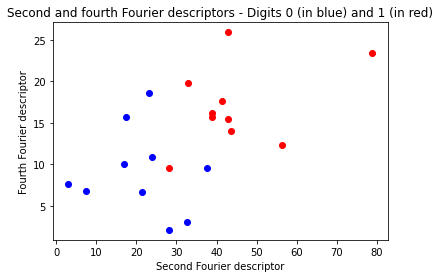

In [39]:
_ = full_descriptors(zeros_im_rotated, ones_im_rotated, invariance = False)

We expected the results to be very similar to the case in which all the invariances were implemented, as the invariance to rotation is still maintained in this case. The results are instead slightly worse, as the classes are not linearly separable anymore.

##### Translation

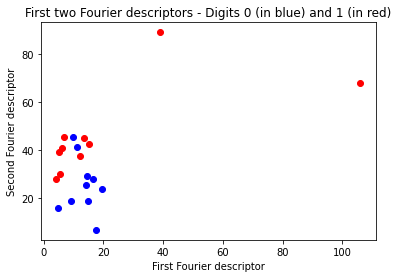

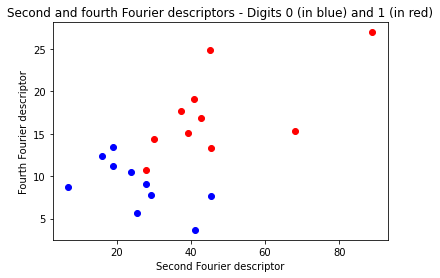

In [40]:
_ = full_descriptors(zeros_im_translated, ones_im_translated, invariance=False)

We expected the results to be very similar to the case in which all the invariances were implemented, as the invariance to translation is still maintained in this case. The results are instead slightly worse, as the classes are not linearly separable anymore.

##### Scaling down

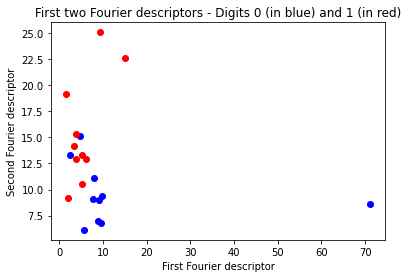

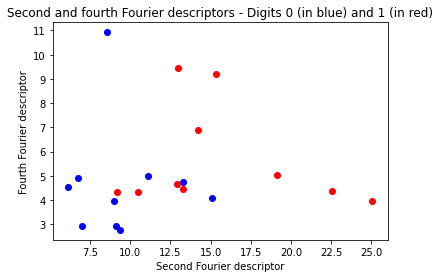

In [41]:
_ = full_descriptors(zeros_im_scale_d_resized, ones_im_scale_d_resized, invariance=False)

We expected the results to be worse than the case in which all the invariances were implemented, as the invariance to rescaling has been removed in this case. Indeed, the results are worse, as the two groups of digits are strongly mingled and definitely not separable.

##### Scaling up

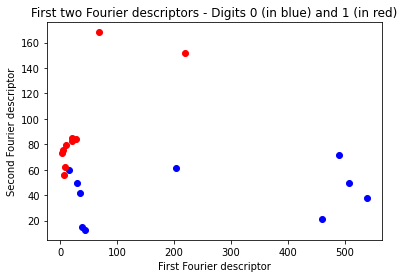

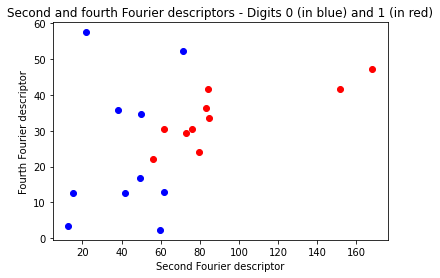

In [42]:
_ = full_descriptors(zeros_im_scale_u_resized, ones_im_scale_u_resized, invariance=False)

We expected the results to be worse than the case in which all the invariances were implemented, as the invariance to rescaling has been removed in this case. Indeed, the results are worse, but the two classes are not as mingled as observed when the digits were downscaled. In any case, the digits are not linearly separable.

Therefore, it is sufficient to remove one of the invariance conditions to worsen the results significantly. This proves that the invariance conditions are effective on the Fourier Descriptors.

### 1.3 Additional method (5 pts)

#### 1.3.1 Preprocessing the digits

We start by determing the Otsu threshold and using it to produce binary images. We need to do an opening on the ones in order not to have problems extracting the properties of the region later.

In [43]:
from skimage.filters import threshold_otsu
from skimage.morphology import opening, square

In [44]:
thresh = threshold_otsu(zeros_im[0])

In [45]:
zeros_binarized=[]
for i in range(len(zeros_im)):
    zeros_binarized.append(zeros_im[i]>thresh)
ones_binarized =[]
for i in range(len(ones_im)):
    ones_binarized.append(opening(ones_im[i]>thresh, square(2)))   # We do binary opening to fix shapes problems

We take a look at the processed digits.

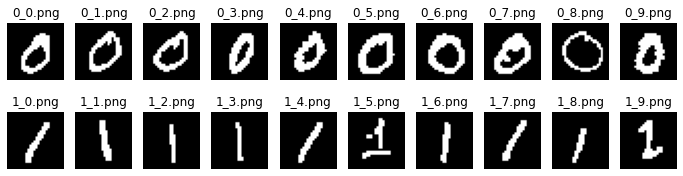

In [46]:
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_binarized, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_binarized, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

#### 1.3.2 Extracting measures with regionprops

Now we extract some measures related to the digits using [regionprops](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops). We will use these measures to then build our descriptors. Note that we need to extract the info also for images of zeros with filled in holes, because we are going to use the area of the filled in zeros  to compute the compactness.

In [47]:
from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes

zeros_info = []
full_zeros_info =[]

for i in range(len(zeros_binarized)):
    zeros_info.append(regionprops(label(zeros_binarized[i])))
    filled = label(binary_fill_holes(zeros_binarized[i]))
    full_zeros_info.append(regionprops(filled))
    

ones_info = []
for i in range(len(ones_binarized)):
    ones_info.append((regionprops(label(ones_binarized[i]))))



#### 1.3.2 Building the Descriptos


We build the following descriptors. [(Source)](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.opening). 

- Elongation

Defined as the ratio between the maximum diameter of the object and its minimum diameter perpendicular to it.
- Extent

Defined as the ratio of pixels in the region to pixels in the total bounding box.

- Euler Number

It is computed as number of connected components subtracted by number of holes

- Eccentricity

The eccentricity is the ratio of the focal distance (distance between focal points) over the major axis length. The value is in the interval [0, 1). When it is 0, the ellipse becomes a circle.

- Compactness

To compute compactness we the Polsby Popper measure [(link)](https://fisherzachary.github.io/public/r-output.html). 

$$PP = 4\pi \cdot \frac{A_{digit}}{P_{digit}^{2}}$$


Note that for computing the compactness we consider a zero with the filled hole, in order to get a meaningfull measure of the area.

In [48]:
zeros_elongation = []  
zeros_euler = []  
zeros_compactness = []  
zeros_eccentricity = []
zeros_extent = []

ones_elongation = []  
ones_euler = []  
ones_compactness = []  
ones_eccentricity = []
ones_extent = []

for i in range(len(zeros_info)):
    zeros_euler.append(zeros_info[i][0].euler_number)
    zeros_compactness.append((4 * np.pi * full_zeros_info[i][0].area) / (full_zeros_info[i][0].perimeter ** 2))
    zeros_elongation.append(zeros_info[i][0].major_axis_length/zeros_info[i][0].minor_axis_length)
    zeros_eccentricity.append(zeros_info[i][0].eccentricity)
    zeros_extent.append(zeros_info[i][0].extent)
    
for i in range(len(ones_info)):
    ones_euler.append(ones_info[i][0].euler_number)
    ones_compactness.append((4 * np.pi * ones_info[i][0].area) /  (ones_info[i][0].perimeter ** 2))
    ones_eccentricity.append(ones_info[i][0].eccentricity)
    ones_extent.append(ones_info[i][0].extent)
    ones_elongation.append(ones_info[i][0].major_axis_length/ones_info[i][0].minor_axis_length)
    

#### 1.3.3 Plotting using the descriptors

We now plot using the descriptors to find out which ones separate better the digits into two clusters. We first consider 2D plots.

We start by plotting the Euler number and the Compactness.

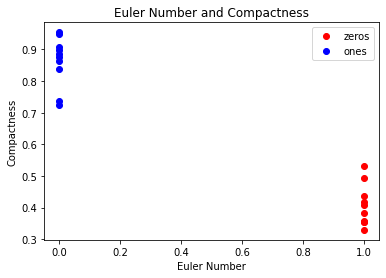

In [49]:
plt.plot(ones_euler, ones_compactness, 'ro', zeros_euler ,zeros_compactness, 'bo')
descriptor1 = 'Euler Number'
descriptor2 = 'Compactness'
plt.xlabel(descriptor1)
plt.ylabel(descriptor2)

plt.legend(('zeros', 'ones'))
plt.title(f"{descriptor1} and {descriptor2}")
plt.show()

Both the Euler Number and the Compactness seem to work very well.

We now plot Extent and Elongation.

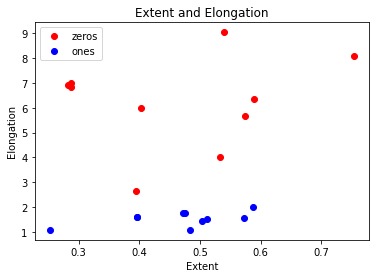

In [50]:
plt.plot(ones_extent, ones_elongation, 'ro',  zeros_extent, zeros_elongation, 'bo')
descriptor1 = 'Extent'
descriptor2 = 'Elongation'
plt.xlabel(descriptor1)
plt.ylabel(descriptor2)

plt.legend(('zeros', 'ones'))
plt.title(f"{descriptor1} and {descriptor2}")
plt.show()

As we can see from the plot above, extent does describe well the differences between the digits.Elongation works better.

We now plot Eccentricity and Elongation.

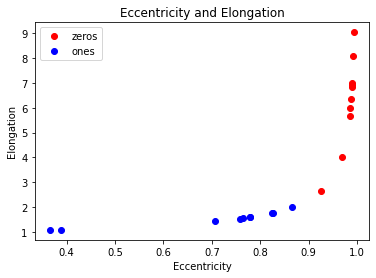

In [51]:
plt.plot(ones_eccentricity, ones_elongation, 'ro',  zeros_eccentricity ,zeros_elongation, 'bo')
descriptor1 = 'Eccentricity'
descriptor2 = 'Elongation'
plt.xlabel(descriptor1)
plt.ylabel(descriptor2)

plt.legend(('zeros', 'ones'))
plt.title(f"{descriptor1} and {descriptor2}")
plt.show()

We now plot the three descriptors that worked best: Compactness, Euler Number and Eccentricity, using a 3D plot.

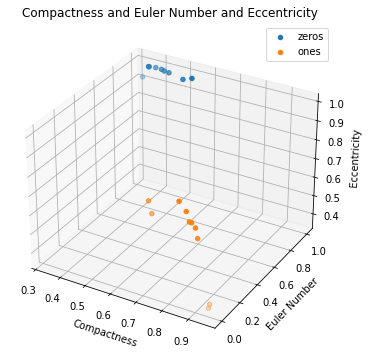

In [52]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(ones_compactness, ones_euler, ones_eccentricity, 'r')
ax.scatter(zeros_compactness, zeros_euler, zeros_eccentricity, 'b')
descriptor1 = 'Compactness'
descriptor2 = 'Euler Number'
descriptor3 = 'Eccentricity'
ax.set_xlabel(descriptor1)
ax.set_ylabel(descriptor2)
ax.set_zlabel(descriptor3)
plt.legend(('zeros', 'ones'))
plt.title(f"{descriptor1} and {descriptor2} and {descriptor3}")
plt.show()

As we can see in the 3D plot above, the two cluster are distant so the result is satisfactory.

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

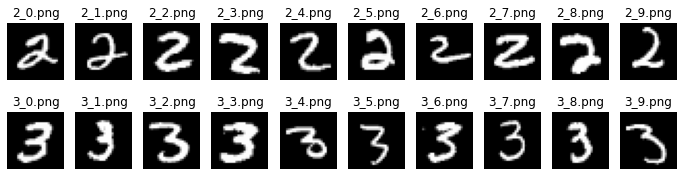

In [53]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

We now use the same procedure explained in part 1.2 ("Fourier descriptors"), and in particular, the functions 'find_single_pixel_contour' and 'visit_contour', but this time we consider four different digits (0, 1, 2, 3) instead of just two (0, 1). The procedure used and the Fourier descriptors considered are exactly the same as before, as we wanted to stay as close as possible to the situation described before to check whether it is still suitable to discriminate all the four digits.

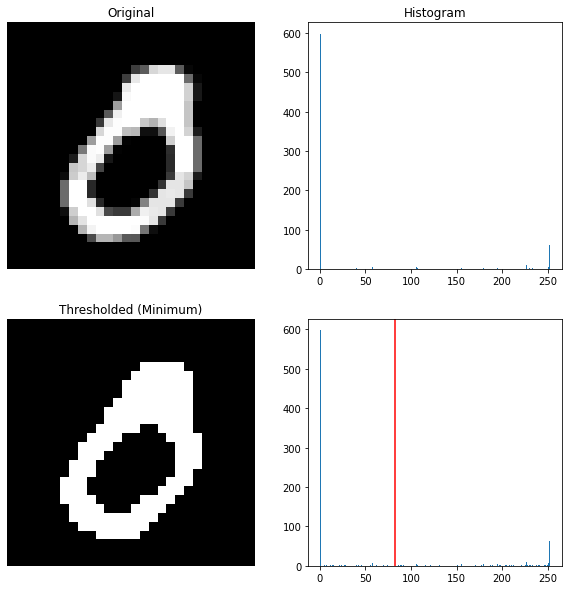

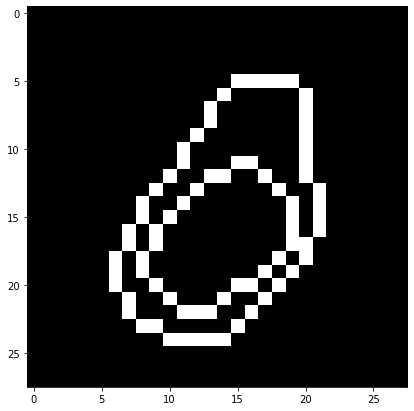

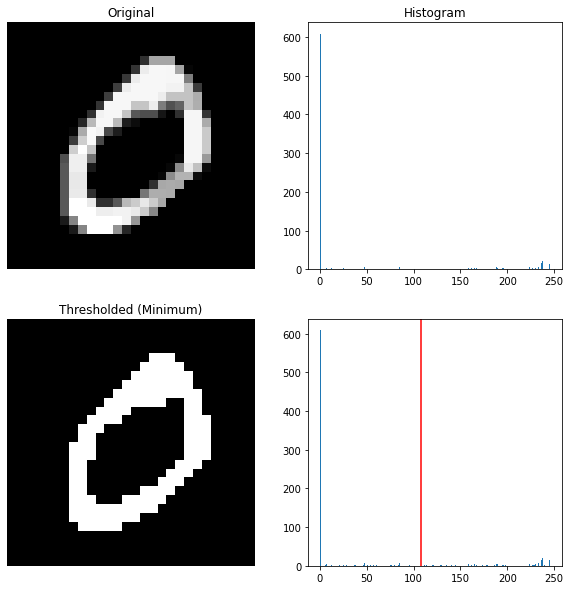

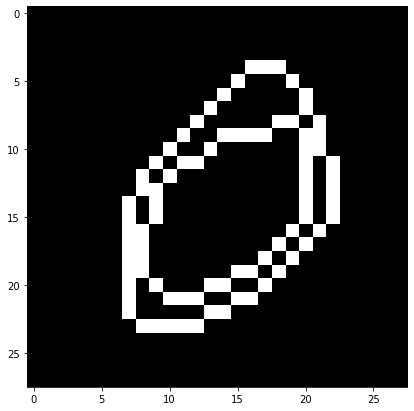

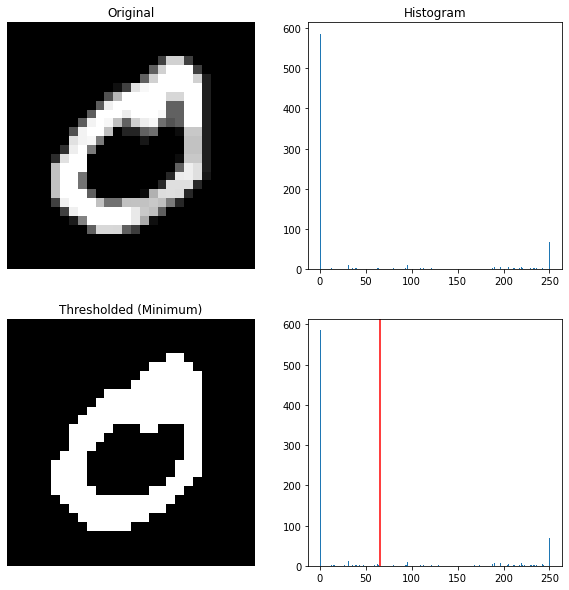

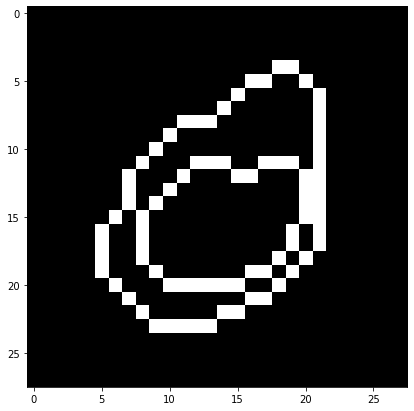

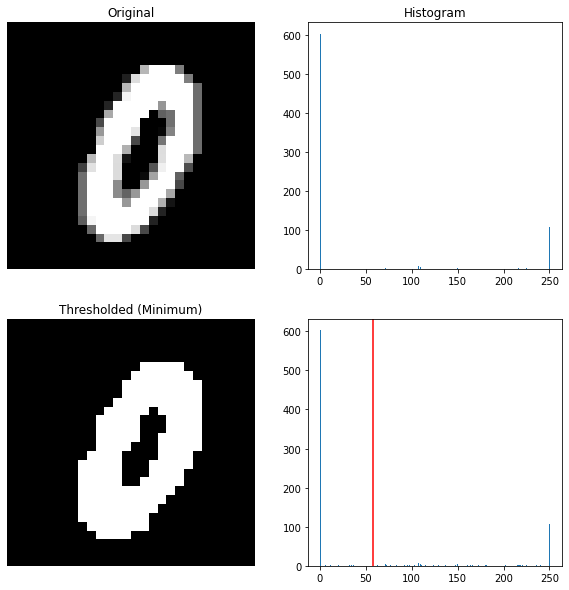

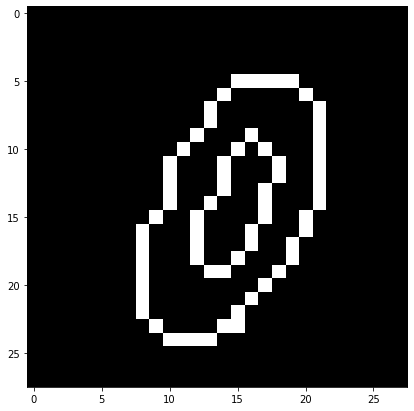

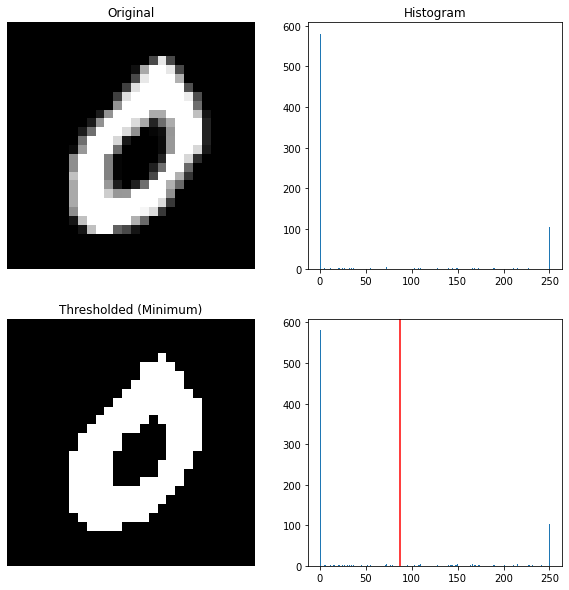

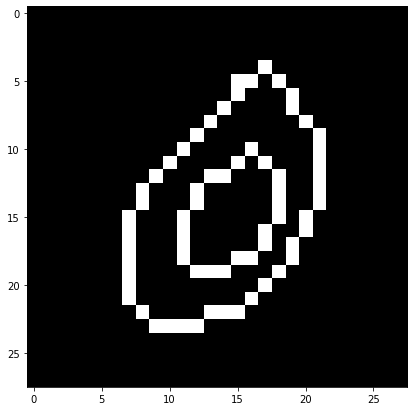

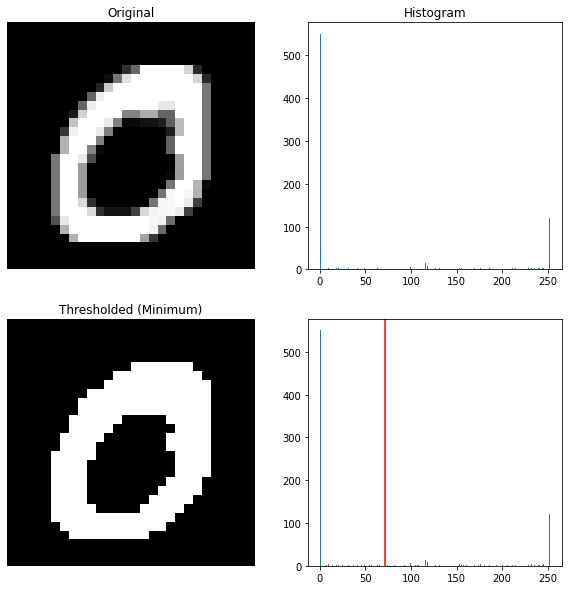

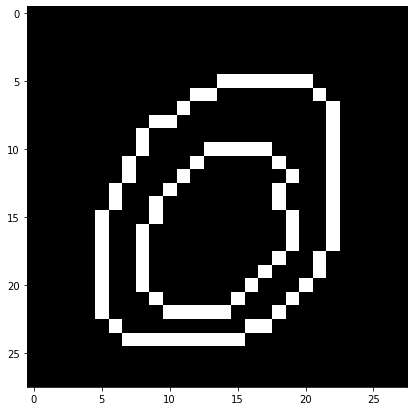

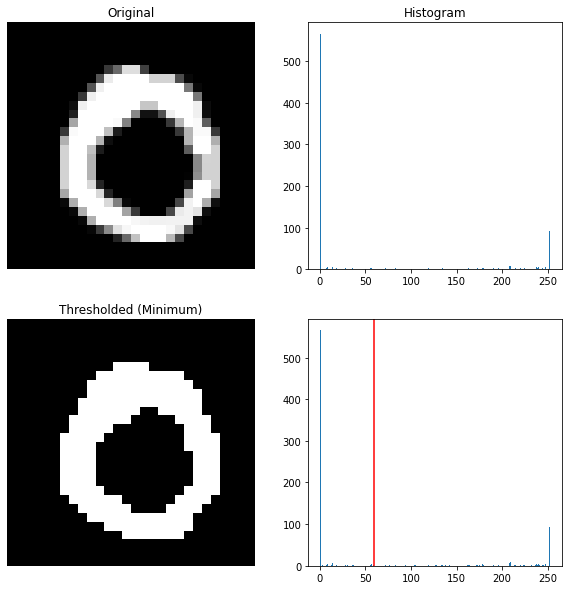

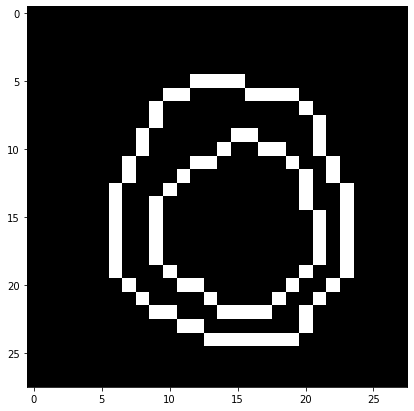

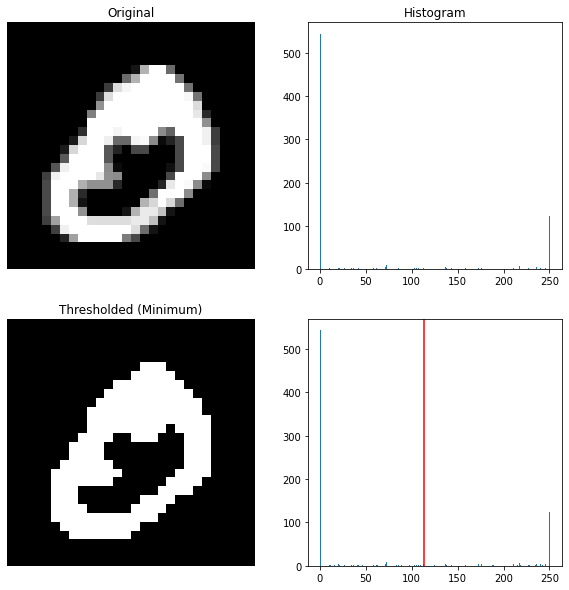

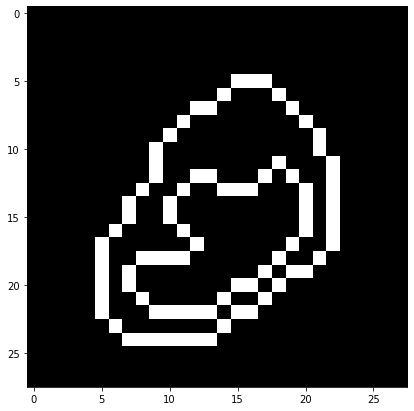

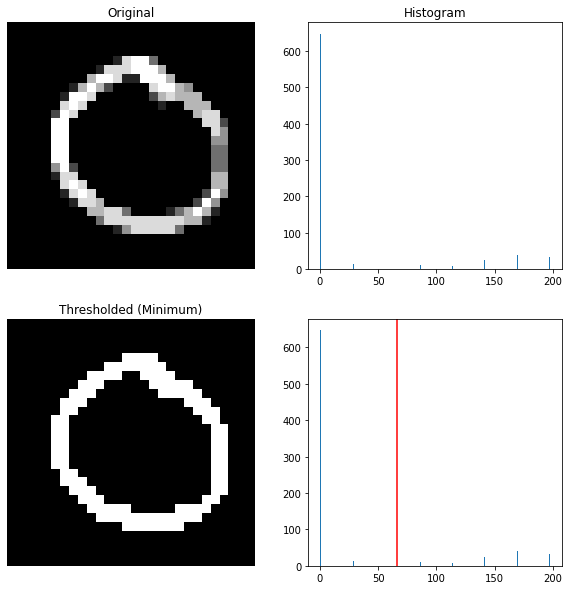

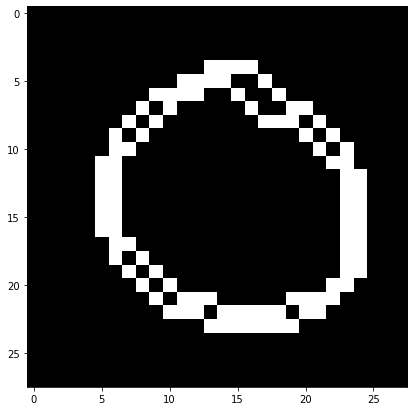

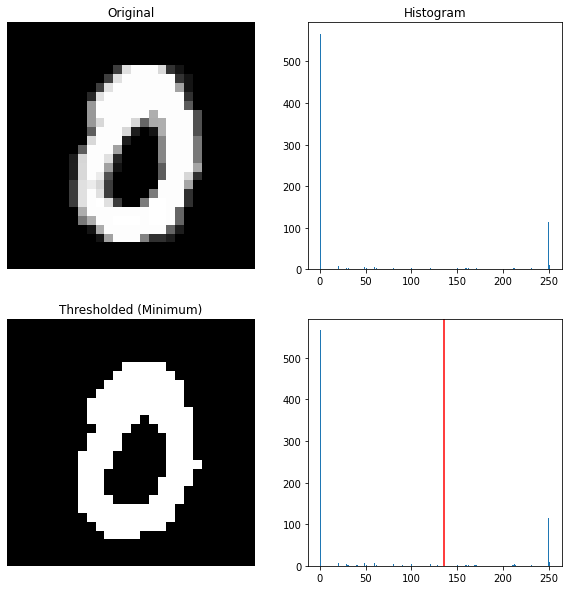

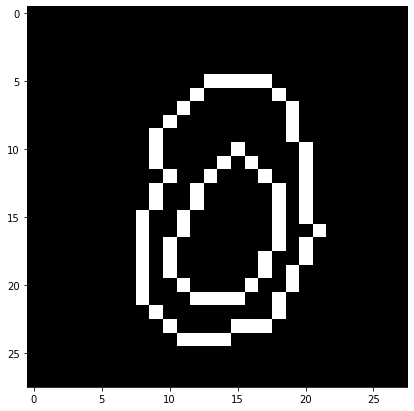

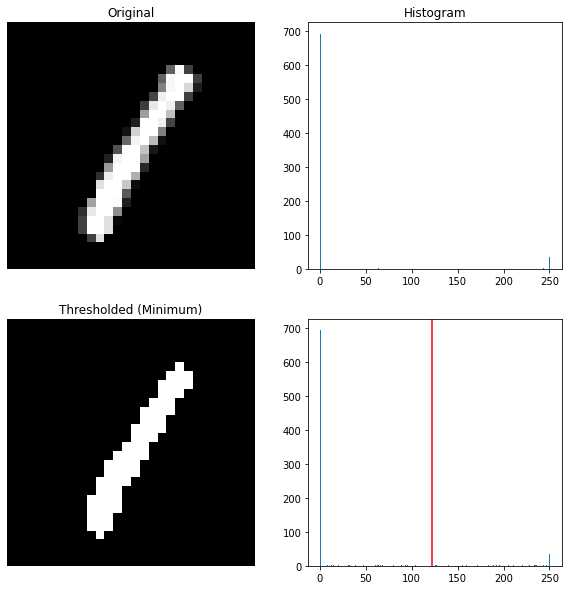

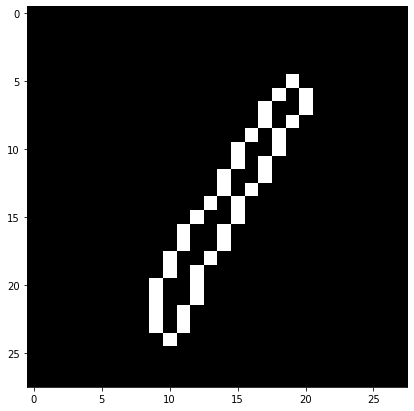

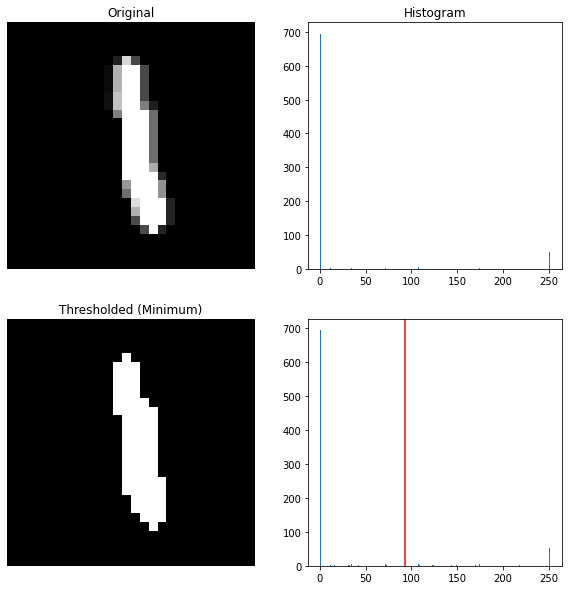

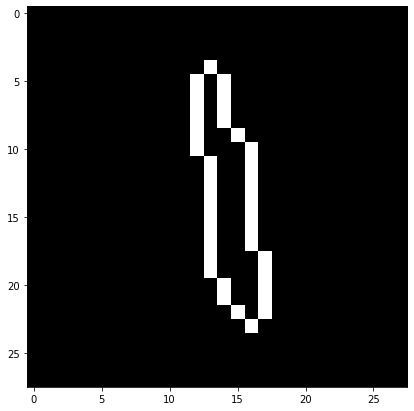

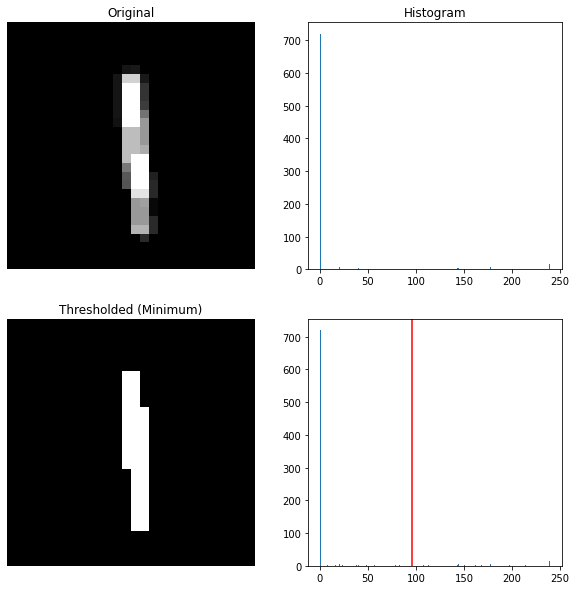

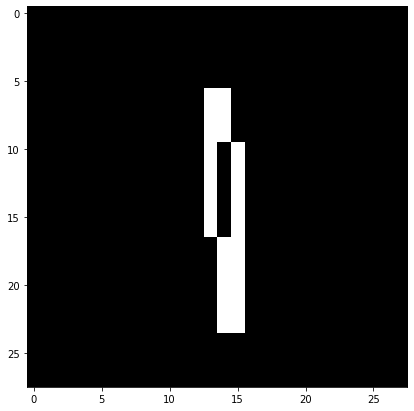

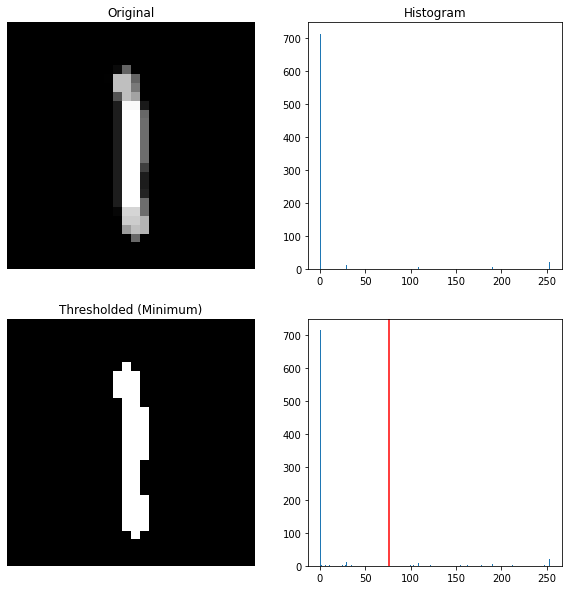

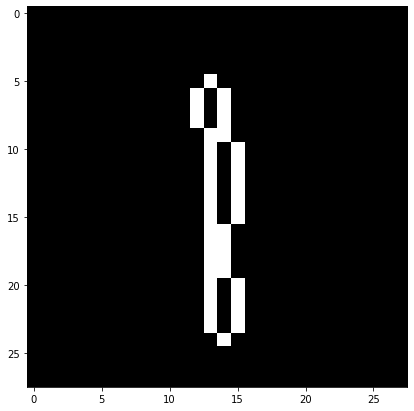

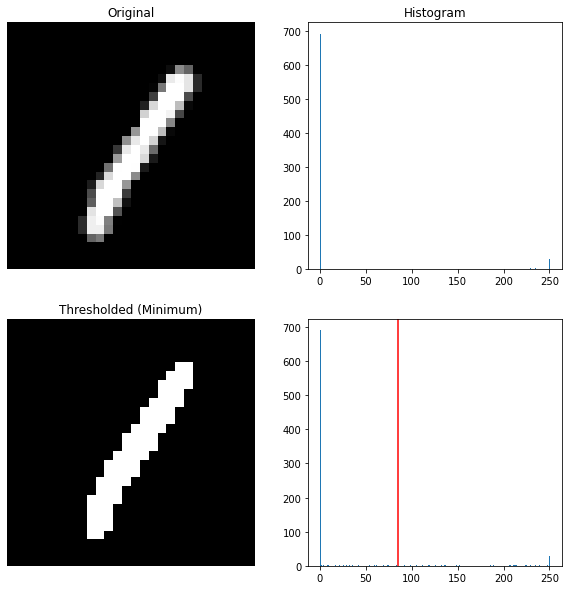

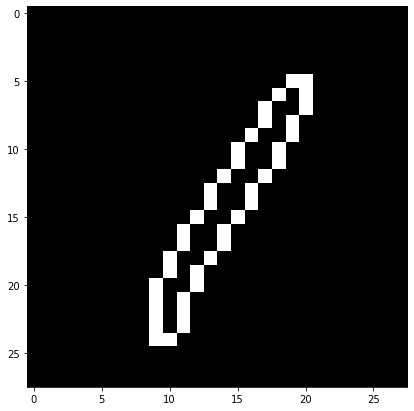

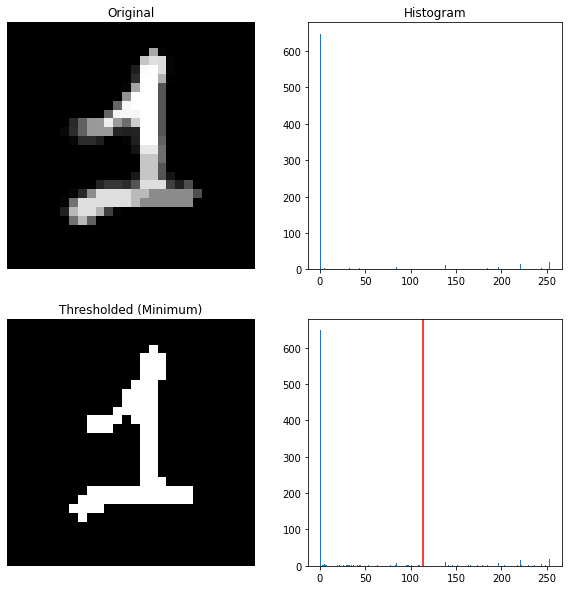

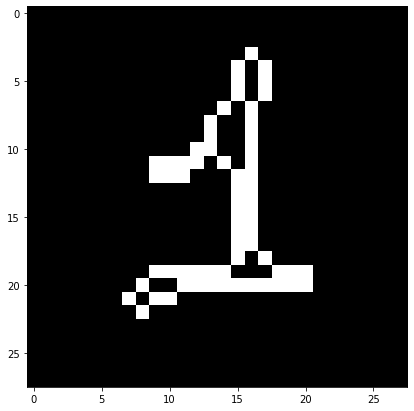

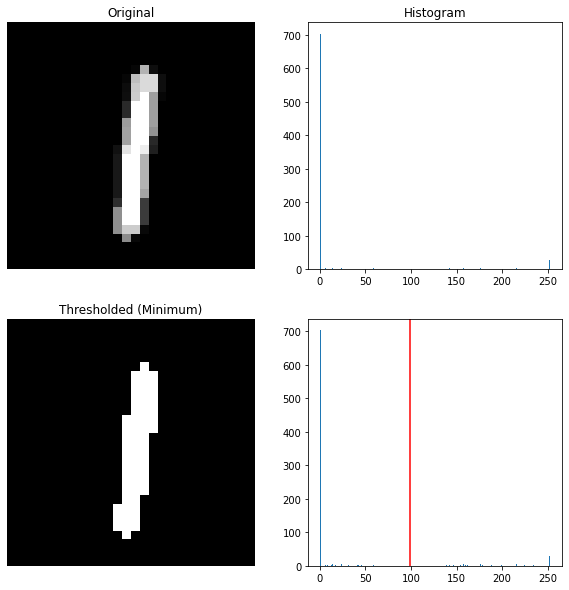

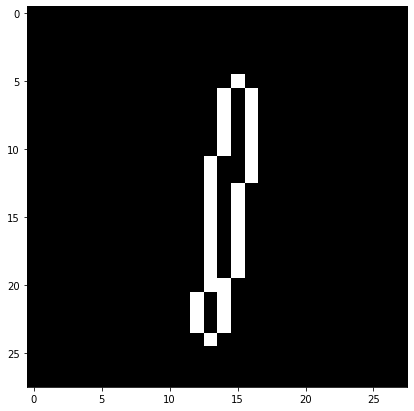

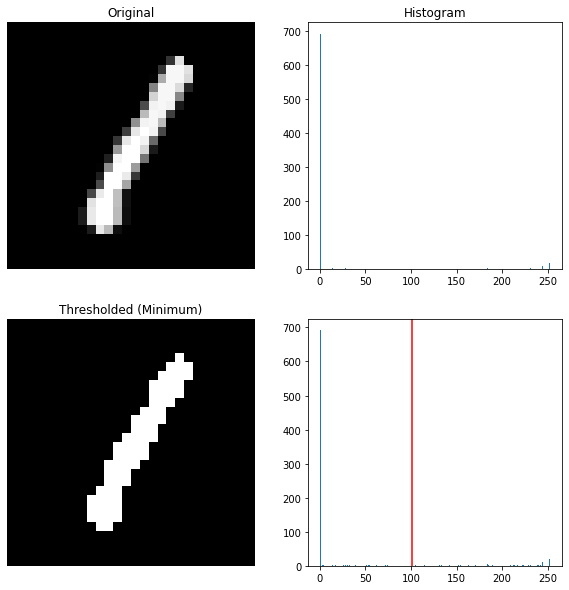

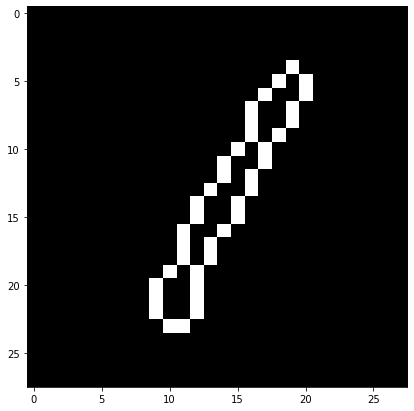

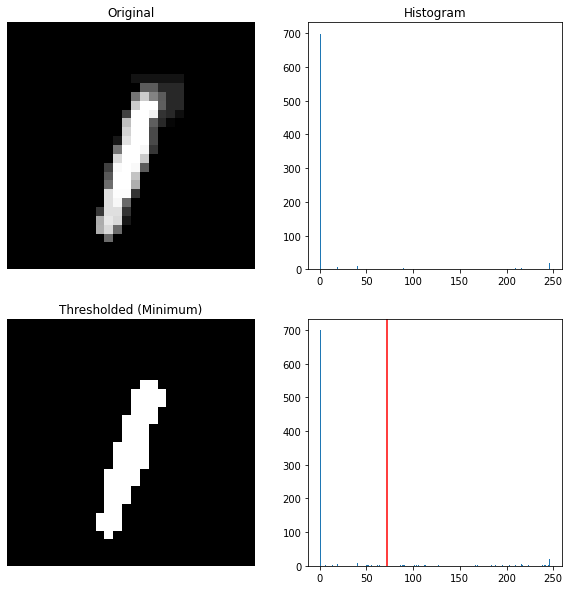

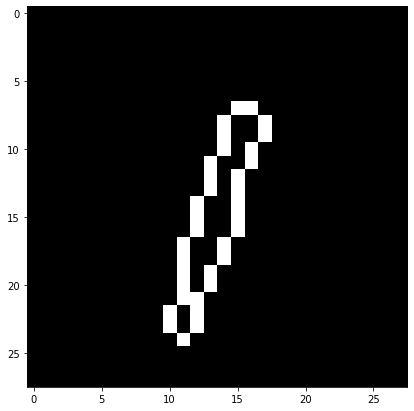

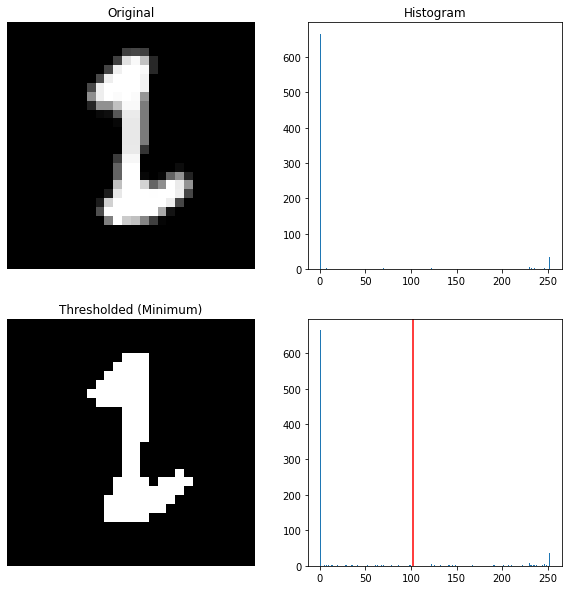

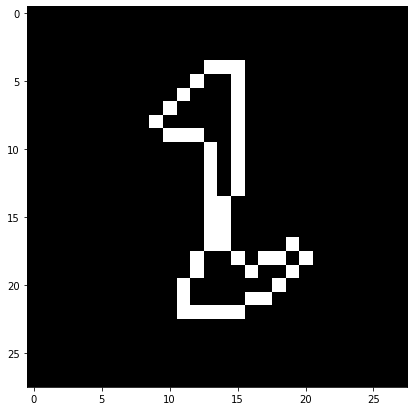

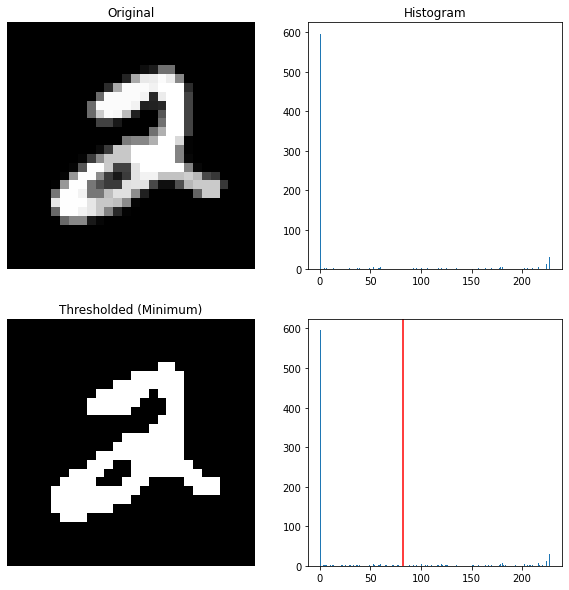

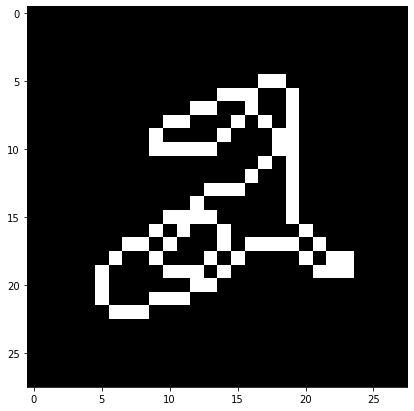

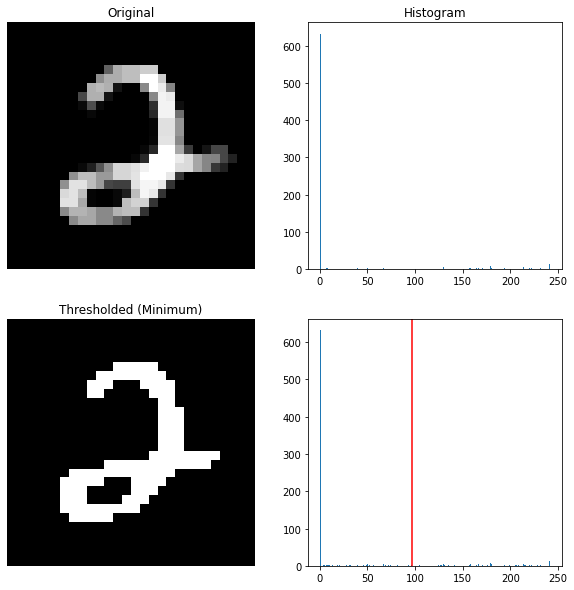

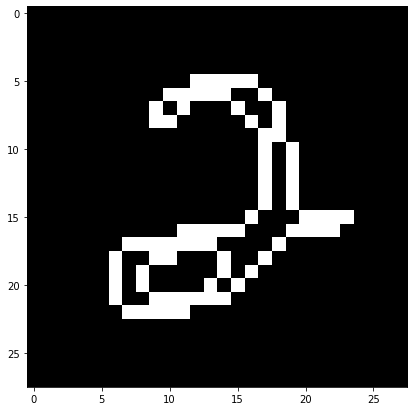

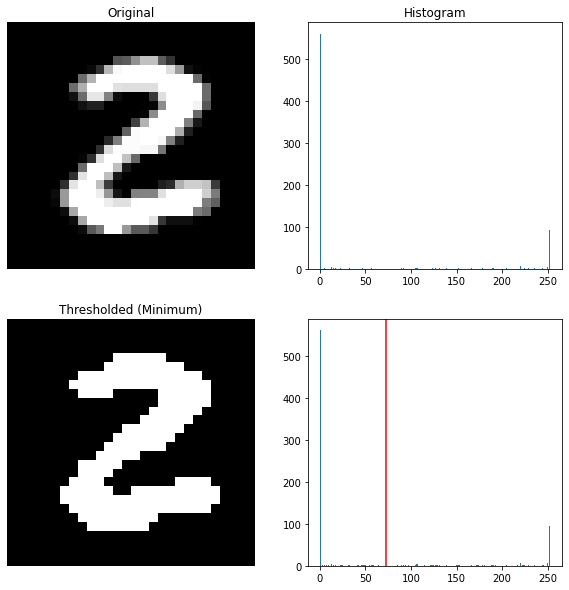

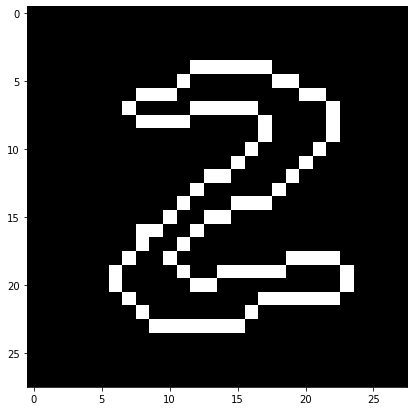

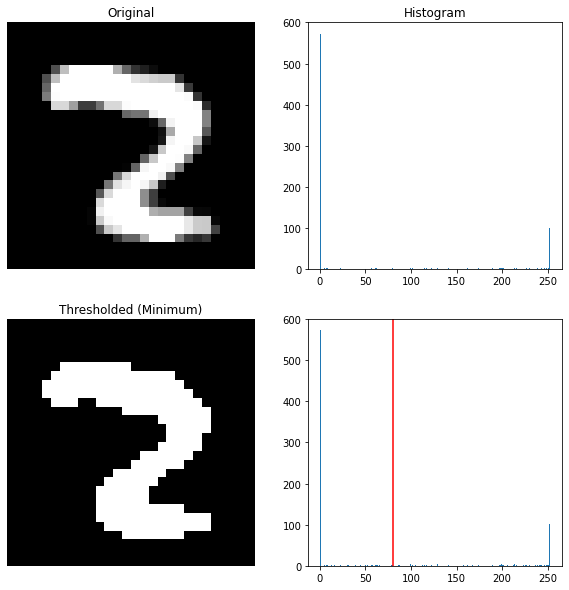

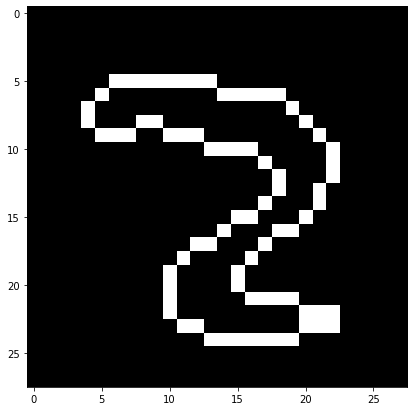

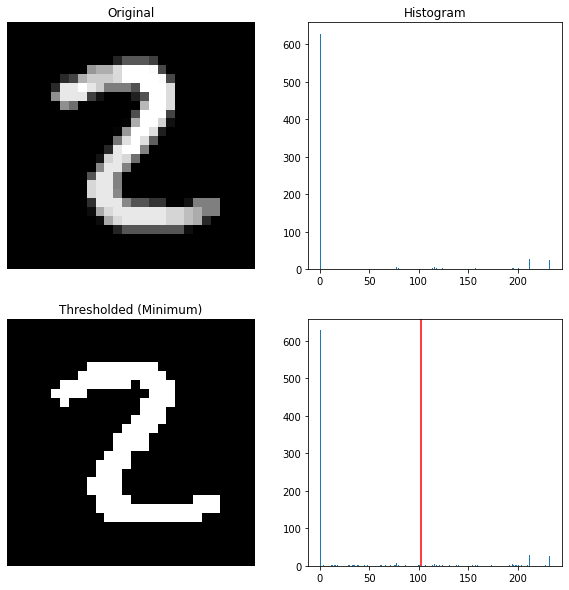

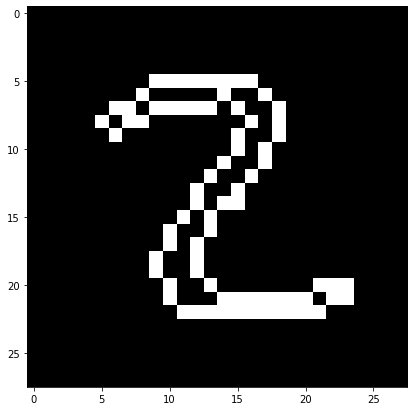

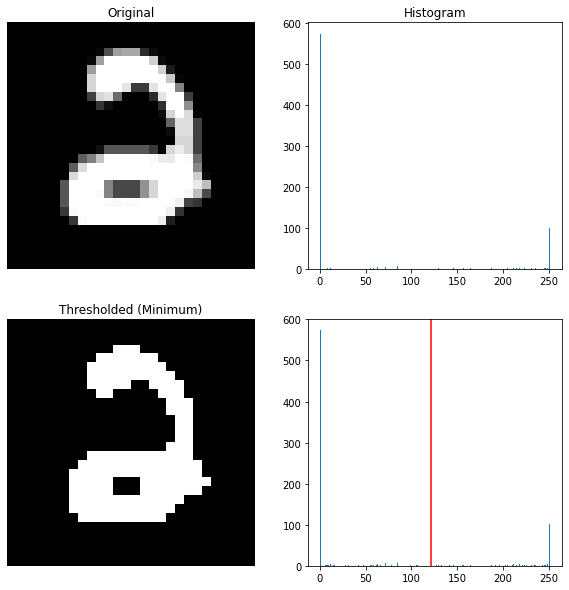

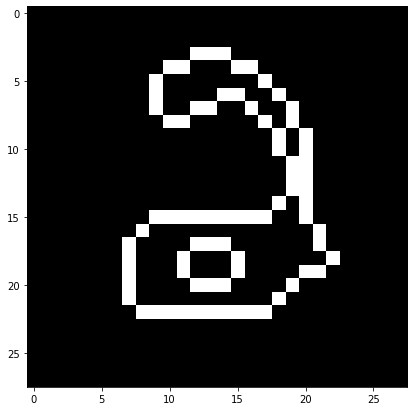

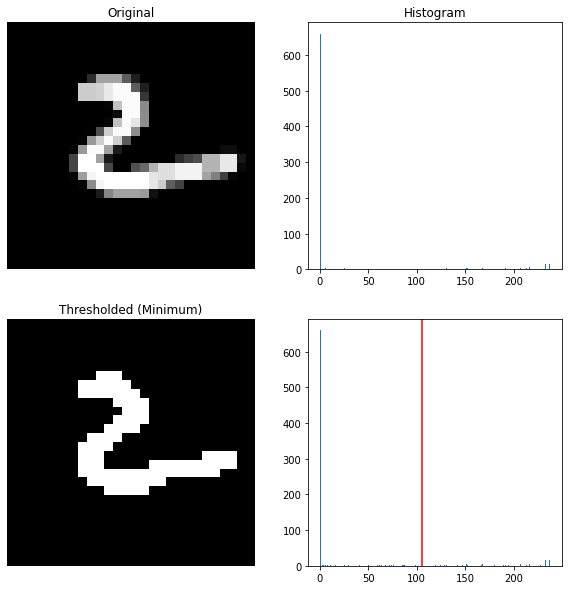

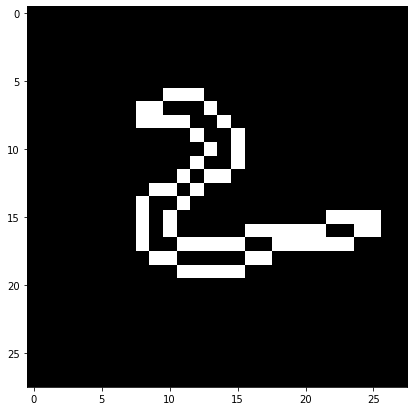

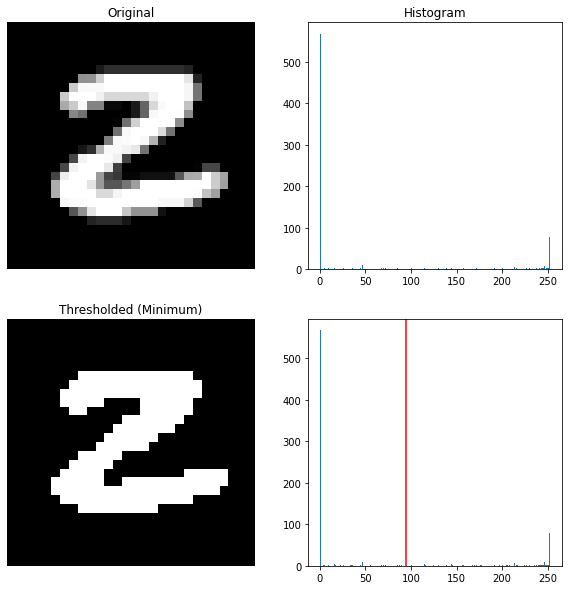

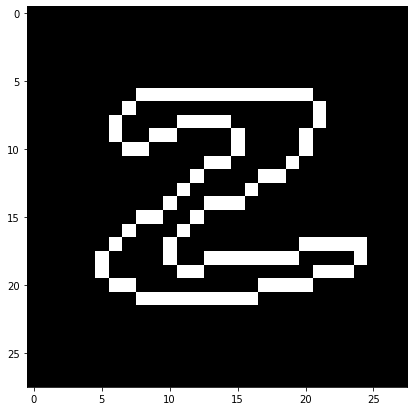

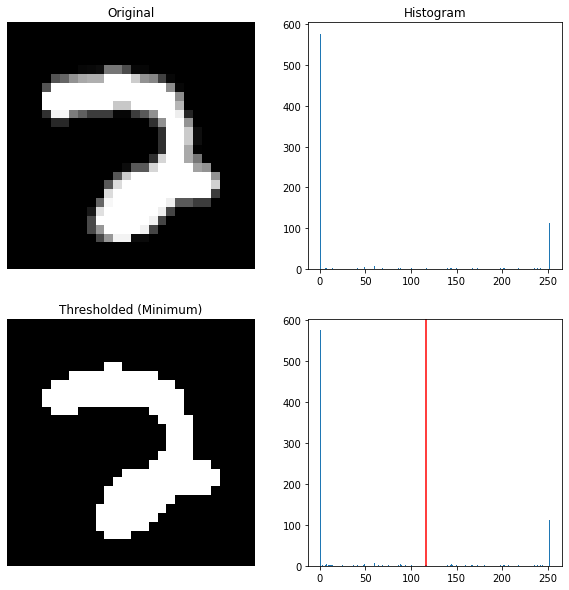

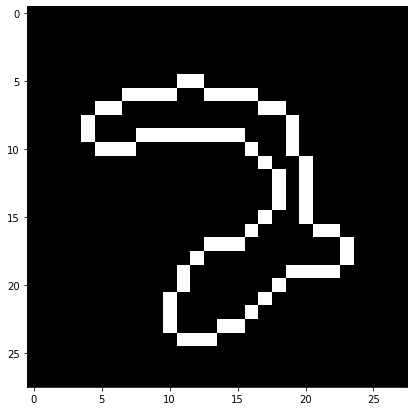

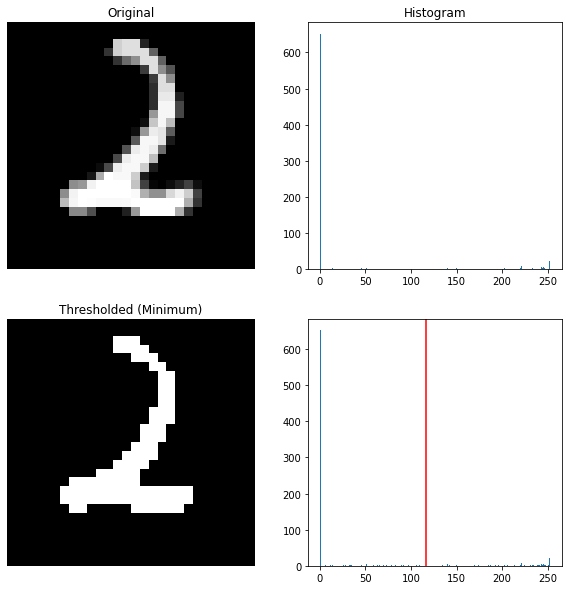

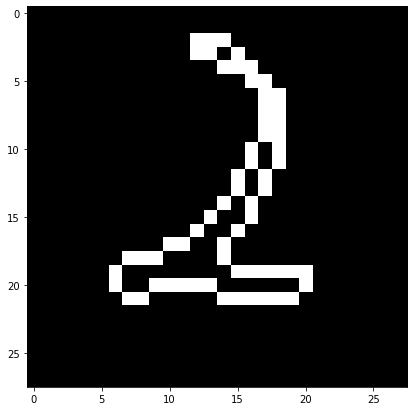

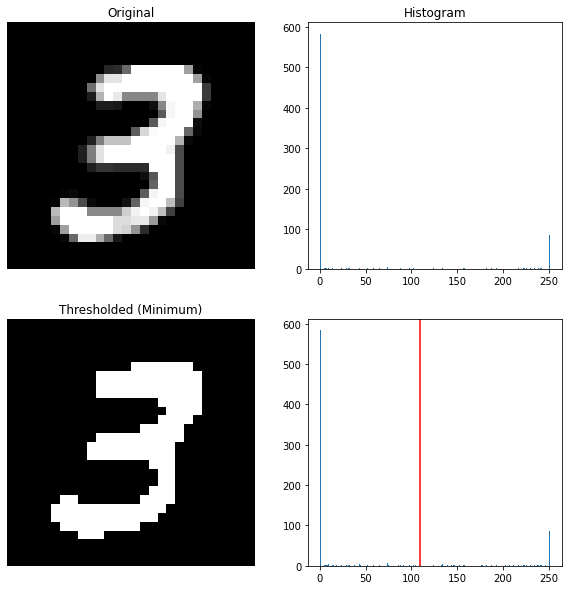

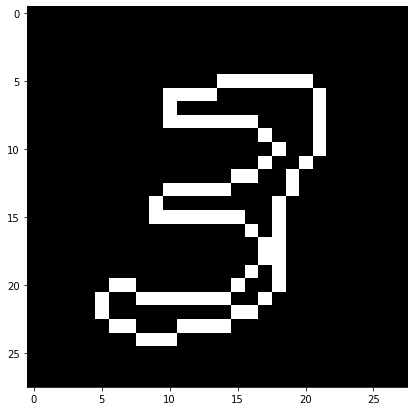

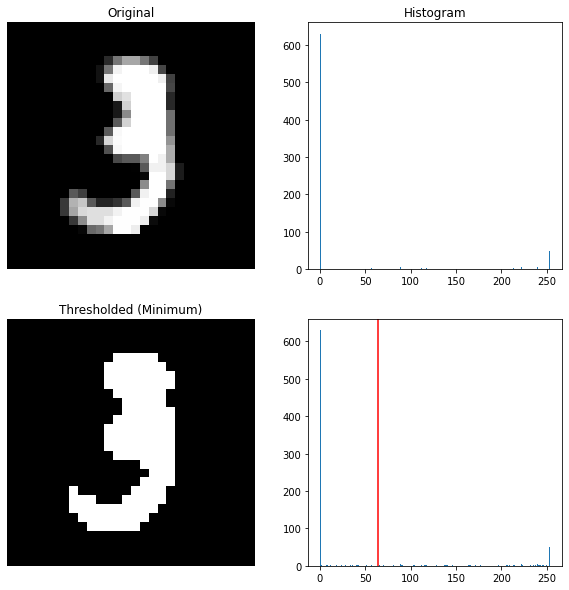

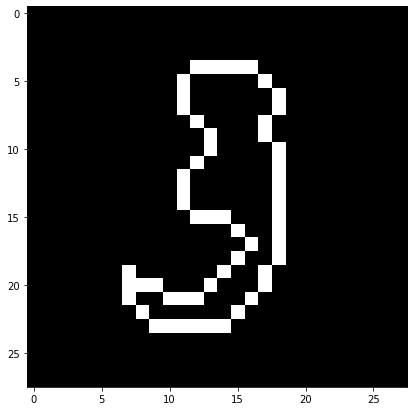

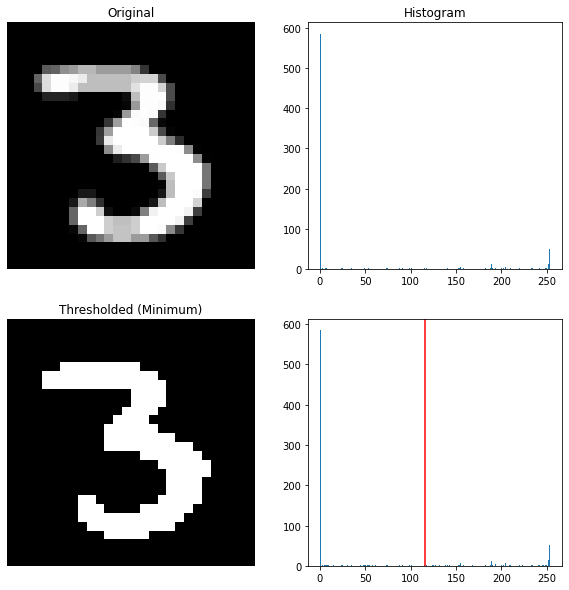

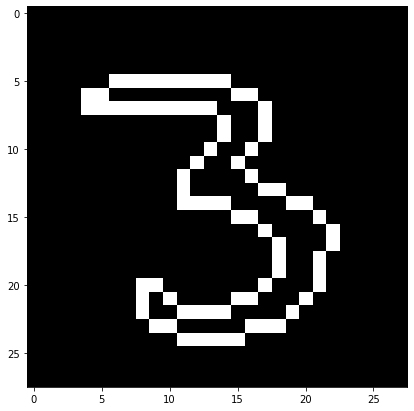

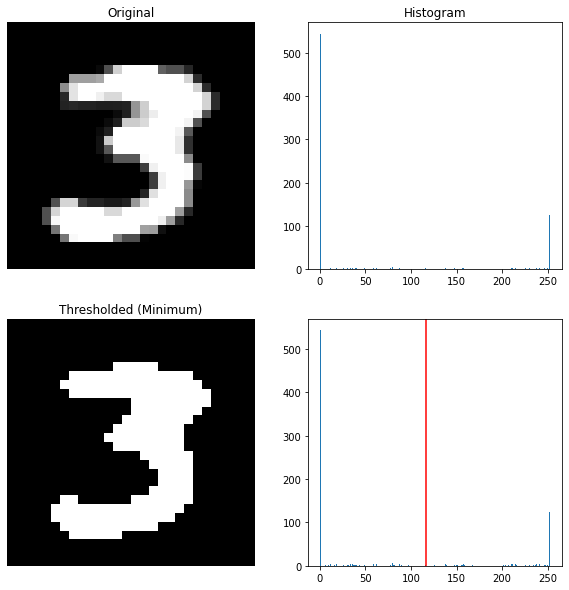

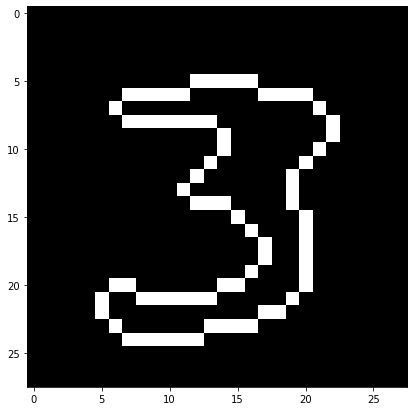

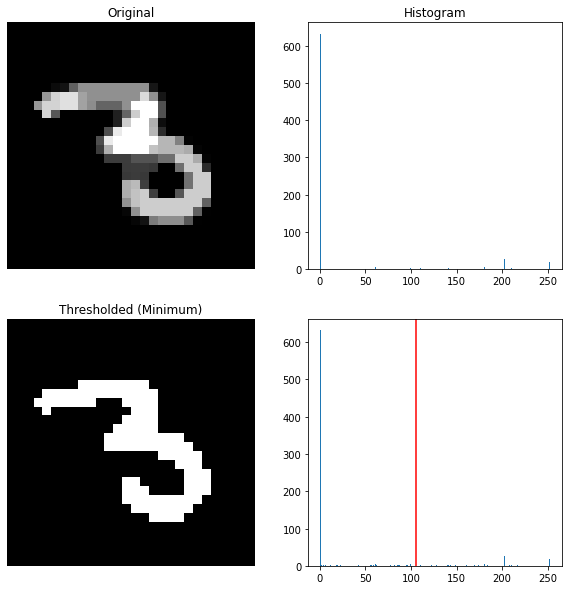

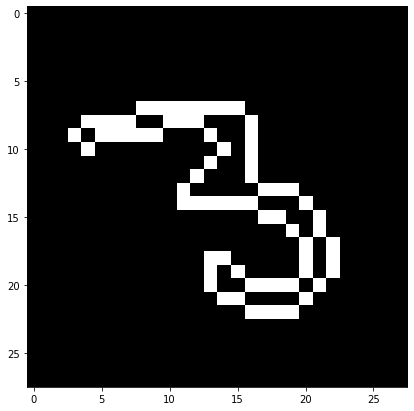

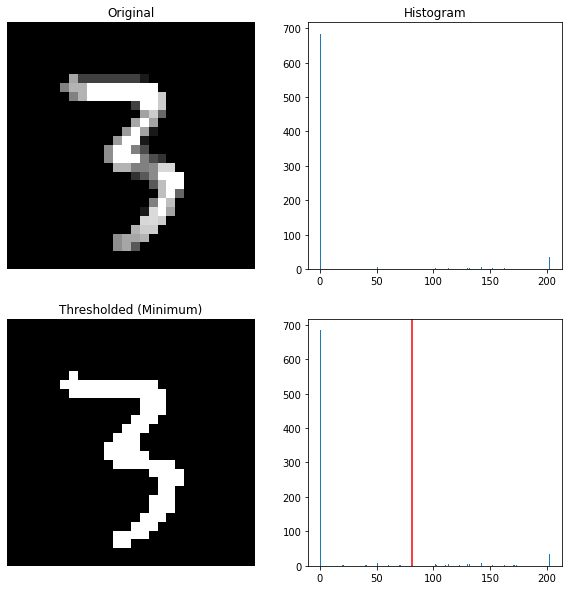

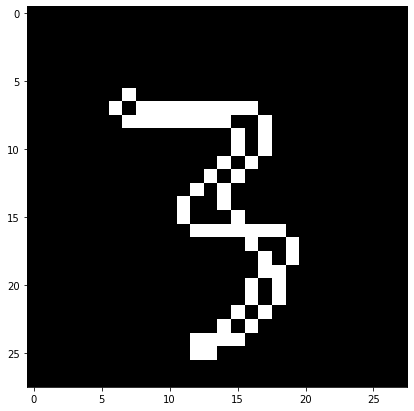

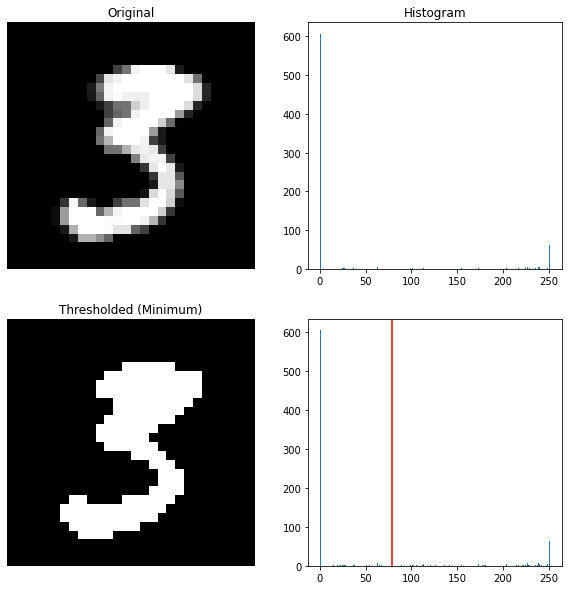

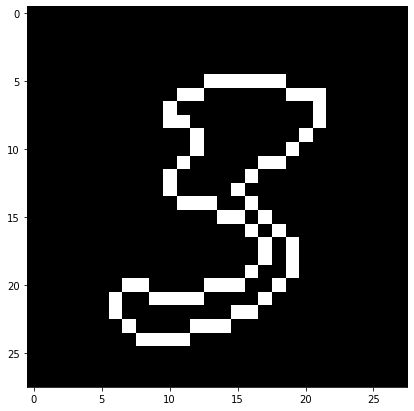

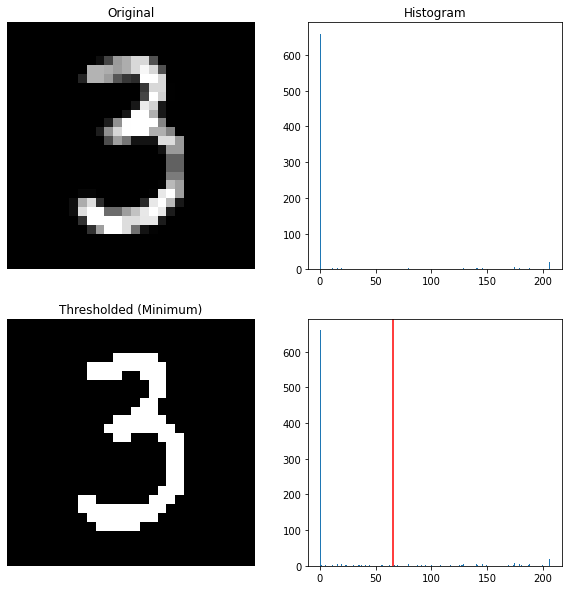

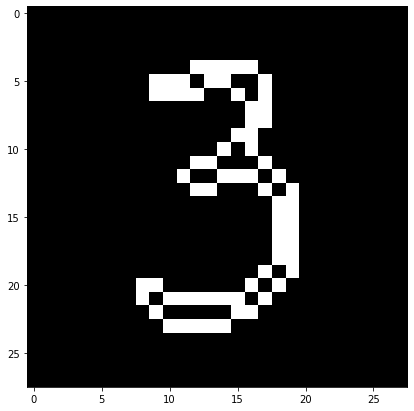

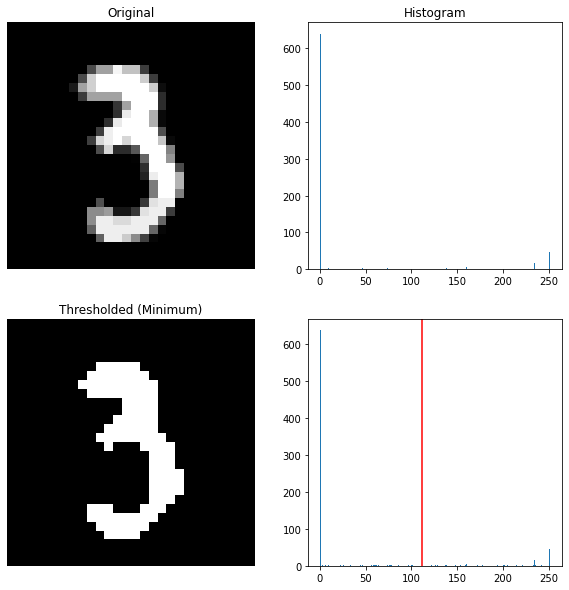

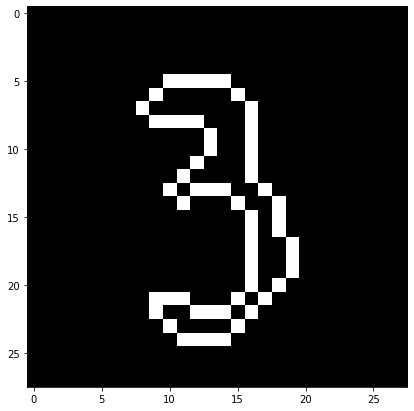

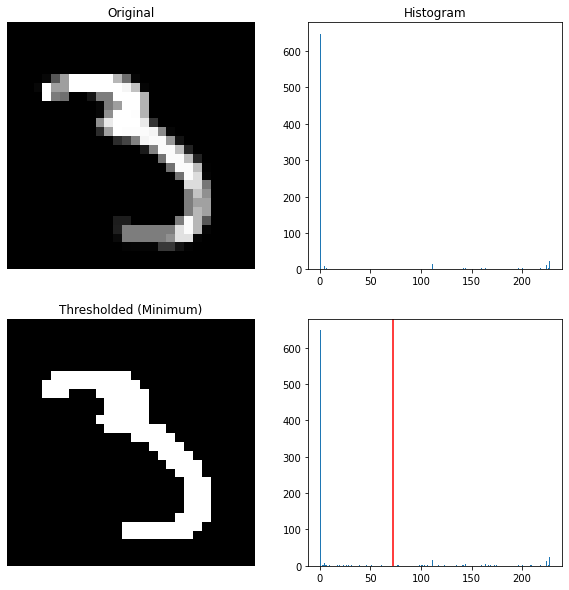

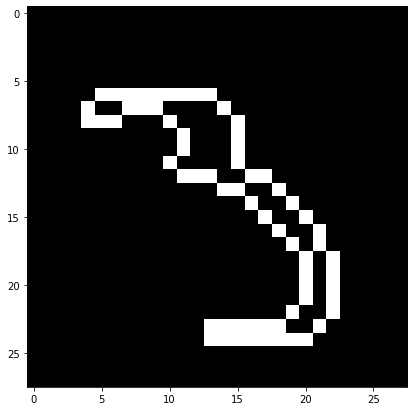

In [54]:
single_pixel_contour_0 = find_single_pixel_contour(zeros_im)
single_pixel_contour_1 = find_single_pixel_contour(ones_im)
single_pixel_contour_2 = find_single_pixel_contour(twos_im)
single_pixel_contour_3 = find_single_pixel_contour(threes_im) 

list_x_all_0, list_y_all_0, max_len_0, cycle_length_0 = visit_contour(single_pixel_contour_0)
list_x_all_1, list_y_all_1, max_len_1, cycle_length_1 = visit_contour(single_pixel_contour_1)
list_x_all_2, list_y_all_2, max_len_2, cycle_length_2 = visit_contour(single_pixel_contour_2)
list_x_all_3, list_y_all_3, max_len_3, cycle_length_3 = visit_contour(single_pixel_contour_3)

max_len = max(max_len_0, max_len_1, max_len_2, max_len_3)

first_descriptor_0, second_descriptor_0 = find_descriptors(list_x_all_0, list_y_all_0, max_len, cycle_length_0, 2, 4)
first_descriptor_1, second_descriptor_1 = find_descriptors(list_x_all_1, list_y_all_1, max_len, cycle_length_1, 2, 4)
first_descriptor_2, second_descriptor_2 = find_descriptors(list_x_all_2, list_y_all_2, max_len, cycle_length_2, 2, 4)
first_descriptor_3, second_descriptor_3 = find_descriptors(list_x_all_3, list_y_all_3, max_len, cycle_length_3, 2, 4)

First of all, it is possible to notice that the procedure to obtain a single-pixel wide contour starting from a grayscale image generalizes well to new digits, particularly to the different twos and threes that are part of the dataset we are considering. The contour is well recognized in all cases, and the original shape is preserved. At this point, we plot the second and fourth Fourier descriptor (that, as shown before, allowed to obtain a great and precise separation between the digits '0' and '1') to check whether it is still possible to discriminate all the digits.

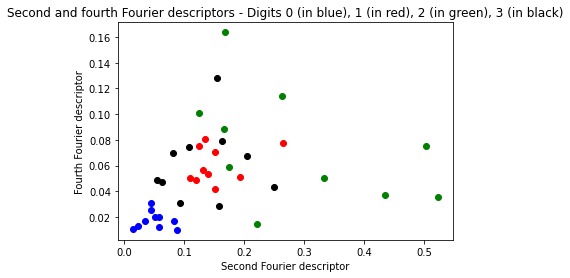

In [55]:
from matplotlib import pyplot as plt
plt.title("Second and fourth Fourier descriptors - Digits 0 (in blue), 1 (in red), 2 (in green), 3 (in black)") 
plt.xlabel("Second Fourier descriptor") 
plt.ylabel("Fourth Fourier descriptor") 
plt.plot(first_descriptor_0, second_descriptor_0, 'ob', first_descriptor_1, second_descriptor_1, 'or', first_descriptor_2, second_descriptor_2, 'og', first_descriptor_3, second_descriptor_3, 'ok') 
plt.show()

It is possible to notice that the results are far from ideal, as it is almost impossible to discriminate the digits '1', '2', and '3'. As expected, more Fourier descriptors would be necessary to be able to discriminate the different digits. For example, in the paper "High accuracy character recognition algorithm using Fourier and topological descriptors", the authors (Shridhar M. and Badreldin A.) state: "Further, it has been observed that only the first few (say 10-15) Fourier coefficients are needed to adequately describe the various characters". Therefore, considering two Fourier descriptors is enough only if we have to discriminate between two classes.

We decided to consider the second and the fourth Fourier descriptors to stay as close as possible to the procedure presented in part 1.2. However, nothing prevents us from finding other descriptors that would be more suited to discriminate the four digits that we are considering (we always have to consider that the first Fourier descriptors are low frequencies and the last ones are high frequencies). Considering the third and the fourth Fourier descriptors allows us to obtain slightly better results, but it is still impossible to discriminate the four digits:

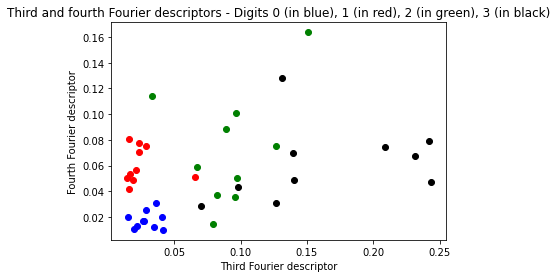

In [56]:
first_descriptor_0, second_descriptor_0 = find_descriptors(list_x_all_0, list_y_all_0, max_len, cycle_length_0, 3, 4)
first_descriptor_1, second_descriptor_1 = find_descriptors(list_x_all_1, list_y_all_1, max_len, cycle_length_1, 3, 4)
first_descriptor_2, second_descriptor_2 = find_descriptors(list_x_all_2, list_y_all_2, max_len, cycle_length_2, 3, 4)
first_descriptor_3, second_descriptor_3 = find_descriptors(list_x_all_3, list_y_all_3, max_len, cycle_length_3, 3, 4)

plt.title("Third and fourth Fourier descriptors - Digits 0 (in blue), 1 (in red), 2 (in green), 3 (in black)") 
plt.xlabel("Third Fourier descriptor") 
plt.ylabel("Fourth Fourier descriptor") 
plt.plot(first_descriptor_0, second_descriptor_0, 'ob', first_descriptor_1, second_descriptor_1, 'or', first_descriptor_2, second_descriptor_2, 'og', first_descriptor_3, second_descriptor_3, 'ok') 
plt.show()

We can observe that we are still unable to separate the four classes, but at least the various groups of points are less mingled than before.